# Packages

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

In [2]:
import csv
import wave
import shutil
import librosa
import pathlib
import numpy as np
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# Constants

In [3]:
SEED = 42
BATCH_SIZE = 32
SAMPLE_RATE = 16000
VALIDATION_SPLIT = 0.2

# Path to the datasets and csv files

The dataset's audio clips are of 6 classes and stored in 6 folders corresponding to each speech command: 
- `ddyo`- `kkono` - `mu maaso` - `emabega` - `yimirira` - `gaali` - `unknown`

In [4]:
train_data_dir = pathlib.Path('Dataset/Train')
test_data_dir = pathlib.Path('Dataset/Test')
aug_train_data_dir = pathlib.Path('Dataset/New_Train')

train_data_needs_preprocessing = pathlib.Path('Dataset/Train_need_preprocessing')
test_data_needs_preprocessing = pathlib.Path('Dataset/Test_need_preprocessing')

train_csv_dir = pathlib.Path('files/train.csv')
test_csv_dir = pathlib.Path('files/test.csv')
aug_train_csv_dir = pathlib.Path('files/aug_train.csv')

## Load sample audio files

In [5]:
emabega_file_path = os.path.join(train_data_dir, 'emabega', 'emabega_001.wav')
ddyo_file_path = os.path.join(train_data_dir, 'ddyo', 'ddyo_001.wav')
yimirira_file_path = os.path.join(train_data_dir, 'yimirira', 'yimirira_015.wav')
kkono_file_path = os.path.join(train_data_dir, 'kkono', 'kkono_001.wav')
mumasso_file_path = os.path.join(train_data_dir, 'mumaaso', 'mumaaso_014.wav')
gaali_file_path = os.path.join(train_data_dir, 'gaali', 'gaali_002.wav')

file_paths = [emabega_file_path, ddyo_file_path, yimirira_file_path, kkono_file_path, mumasso_file_path, gaali_file_path]

In [6]:
emabega_file_path_np = os.path.join(aug_train_data_dir, 'emabega', 'emabega_001np.wav')
ddyo_file_path_np = os.path.join(aug_train_data_dir, 'ddyo', 'ddyo_001np.wav')
yimirira_file_path_np = os.path.join(aug_train_data_dir, 'yimirira', 'yimirira_015np.wav')
kkono_file_path_np = os.path.join(aug_train_data_dir, 'kkono', 'kkono_001np.wav')
mumasso_file_path_np = os.path.join(aug_train_data_dir, 'mumaaso', 'mumaaso_014np.wav')
gaali_file_path_np = os.path.join(aug_train_data_dir, 'gaali', 'gaali_002np.wav')

file_paths_np = [emabega_file_path_np, ddyo_file_path_np, yimirira_file_path_np, kkono_file_path_np, mumasso_file_path_np, gaali_file_path_np]

# Exploratory Data Analysis

## Directory structure

In [7]:
def print_directory_tree(root_dir, indent=''):
    print(indent + os.path.basename(root_dir) + os.path.sep)
    indent += '    '
    for item in os.listdir(root_dir):
        item_path = os.path.join(root_dir, item)
        if os.path.isdir(item_path):
            print_directory_tree(item_path, indent)

In [8]:
print_directory_tree(train_data_dir)

Train/
    emabega/
    mumaaso/
    yimirira/
    ddyo/
    kkono/


In [9]:
print_directory_tree(test_data_dir)

Test/
    emabega/
    mumaaso/
    yimirira/
    ddyo/
    kkono/


In [10]:
# print_directory_tree(aug_train_data_dir)

## Labels
- `ddyo`- `kkono` - `mu maaso` - `emabega` - `yimirira` - `gaali` - `unknown`

In [11]:
def list_directory_contents(directory, label):
    contents = np.array(tf.io.gfile.listdir(str(directory)))
    print(f'{label} commands labels: {contents}')
    return contents

In [12]:
train_commands = list_directory_contents(train_data_dir, 'Train')
test_commands = list_directory_contents(test_data_dir, 'Test')

Train commands labels: ['emabega' 'mumaaso' 'yimirira' 'ddyo' 'kkono']
Test commands labels: ['emabega' 'mumaaso' 'yimirira' 'ddyo' 'kkono']


## Check audio files
Remove audio files that are
Remove audios that are
- `Duration more than 2 seconds and duration == 0`
- `Audios that do not have mono channel`

and move them to the process folder

In [13]:
# Function to move audio files of duration > 2 seconds or !mono-channel or duration == 0 to the process folder
def move_and_count_audio_files(data_dir, process_folder):
    try:
        if not os.path.exists(process_folder):
            os.makedirs(process_folder)
        count = 0
        for subfolder in os.listdir(data_dir):
            subfolder_path = os.path.join(data_dir, subfolder)
            if os.path.isdir(subfolder_path):
                for audio_file in os.listdir(subfolder_path):
                    audio_path = os.path.join(subfolder_path, audio_file)
                    try:
                        with wave.open(audio_path, 'r') as wav_file:
                            audio_length = wav_file.getnframes() / wav_file.getframerate()
                            num_channels = wav_file.getnchannels()
                        if audio_length > 2.0 or num_channels != 1 or audio_length == 0.0:
                            shutil.move(audio_path, os.path.join(process_folder, audio_file))
                            count += 1
                    except Exception as e:
                        print(f"Error processing {audio_path}: {e}")
                        continue

        print(f"{count} {data_dir} audio files moved to {process_folder}.")
    except Exception as e:
        print(f"An error occurred while moving and counting audio files: {e}")
        return 0

In [14]:
move_and_count_audio_files(train_data_dir, train_data_needs_preprocessing)
move_and_count_audio_files(test_data_dir, test_data_needs_preprocessing)

0 Dataset/Train audio files moved to Dataset/Train_need_preprocessing.
0 Dataset/Test audio files moved to Dataset/Test_need_preprocessing.


## CSV files for the audio files

In [15]:

# Function to create a CSV file for audio files
def create_csv_for_audio_files(data_dir, csv_file_path):
    try:
        with open(csv_file_path, 'w', newline='') as csvfile:
            fieldnames = ['audio_file', 'duration', 'num_channels', 'path', 'intent']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for subfolder in os.listdir(data_dir):
                subfolder_path = os.path.join(data_dir, subfolder)
                if os.path.isdir(subfolder_path):
                    for audio_file in os.listdir(subfolder_path):
                        if not audio_file.endswith('.wav'):
                            continue
                        audio_path = os.path.join(subfolder_path, audio_file)
                        try:
                            with wave.open(audio_path, 'r') as wav_file:
                                audio_length = wav_file.getnframes() / wav_file.getframerate()
                                num_channels = wav_file.getnchannels()
                            writer.writerow({'audio_file': audio_file, 'duration': audio_length, 'num_channels': num_channels, 'path': audio_path, 'intent': subfolder})
                        except Exception as e:
                            print(f"Error processing {audio_path}: {e}")
                            continue
    except Exception as e:
        print(f"An error occurred while creating CSV file: {e}")

In [16]:
create_csv_for_audio_files(test_data_dir, test_csv_dir)
create_csv_for_audio_files(train_data_dir, train_csv_dir)
create_csv_for_audio_files(aug_train_data_dir, aug_train_csv_dir)

## Number of audio files

### Train dataset

In [17]:
# Function to count the number of audio files in each subfolder of a directory
def count_audio_files_in_subfolders(data_dir):
    counts = {}
    try:
        for subfolder in os.listdir(data_dir):
            subfolder_path = os.path.join(data_dir, subfolder)
            if os.path.isdir(subfolder_path):
                audio_files_count = len([f for f in os.listdir(subfolder_path) if f.endswith('.wav')])
                counts[subfolder] = audio_files_count
                print(f'Total audio files in {subfolder}: {audio_files_count}')
    except Exception as e:
        print(f"An error occurred while processing the directory: {e}")
    return counts

In [18]:
def plot_audio_files_bar(counts, title):
    if not counts:
        print("Error: The input dictionary is empty.")
        return
    try:
        plt.figure(figsize=(12, 5))
        keys, values = list(counts.keys()), list(counts.values())
        bars = plt.bar(keys, values, color='green')
        plt.xlabel('Command labels')
        plt.ylabel('Number of Audio Files')
        plt.title(title)
        plt.grid(False)  # Remove grid lines
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')
        plt.show()
    except Exception as e:
        print(f"Error: {str(e)}")

In [19]:
counts_train = count_audio_files_in_subfolders(train_data_dir)

Total audio files in emabega: 1238
Total audio files in mumaaso: 1203
Total audio files in yimirira: 1235
Total audio files in ddyo: 1201
Total audio files in kkono: 1209


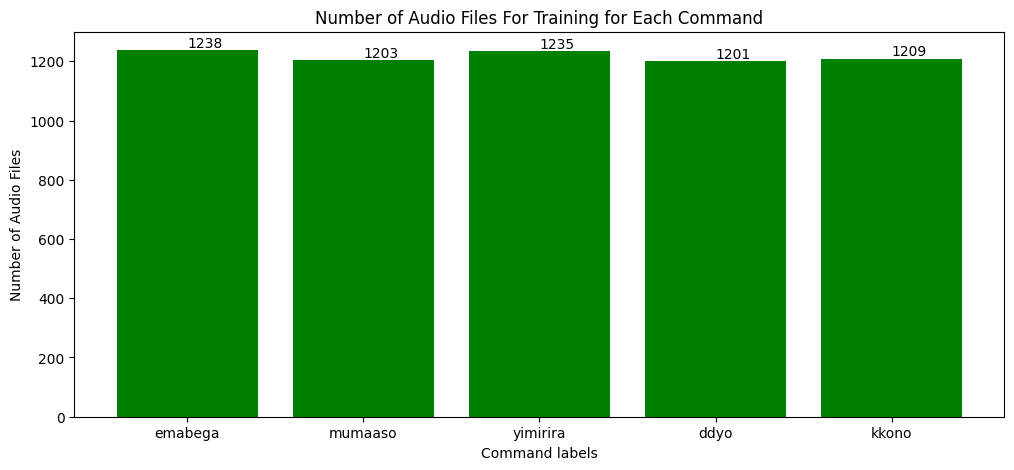

In [20]:
plot_audio_files_bar(counts_train, 'Number of Audio Files For Training for Each Command')

### Test dataset


In [21]:
counts_test = count_audio_files_in_subfolders(test_data_dir)

Total audio files in emabega: 300
Total audio files in mumaaso: 300
Total audio files in yimirira: 300
Total audio files in ddyo: 300
Total audio files in kkono: 300


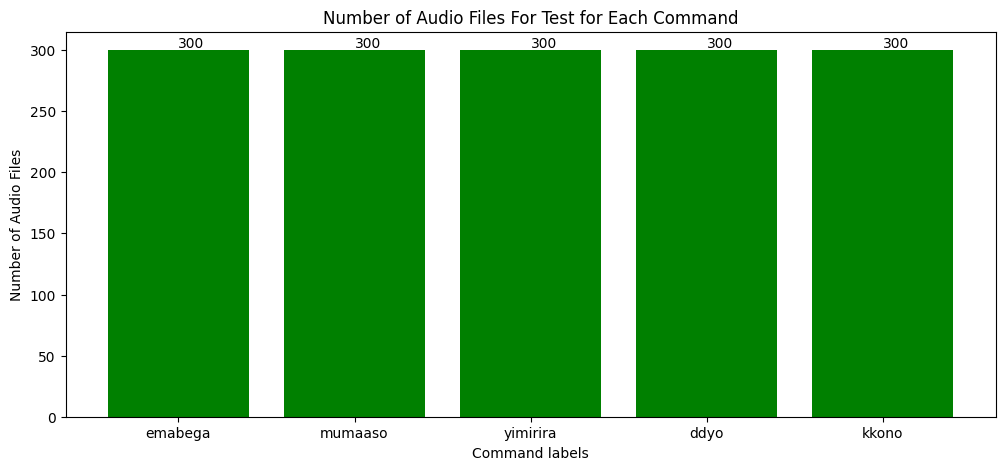

In [22]:
plot_audio_files_bar(counts_test, 'Number of Audio Files For Test for Each Command')

### Augmentated dataset

In [23]:
counts_aug_train = count_audio_files_in_subfolders(aug_train_data_dir)

Total audio files in emabega: 2476
Total audio files in mumaaso: 2406
Total audio files in yimirira: 2470
Total audio files in ddyo: 2402
Total audio files in kkono: 2418


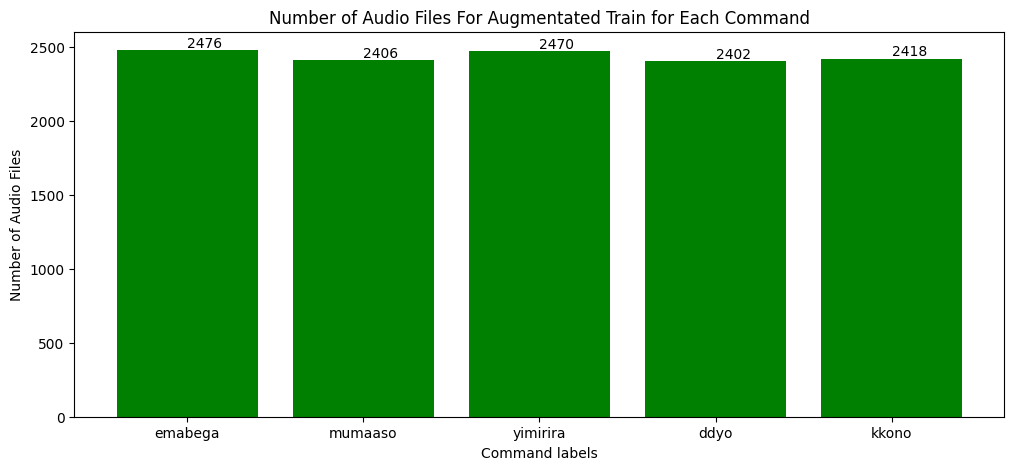

In [24]:
plot_audio_files_bar(counts_aug_train, 'Number of Audio Files For Augmentated Train for Each Command')

### Train and Test counts


In [25]:
# Function to plot the count of audio files for training and testing
def plot_audio_files_comparison(train_counts, test_counts):
    if not train_counts or not test_counts:
        print("Error: The input dictionaries are empty.")
        return
    try:
        plt.figure(figsize=(12, 5))
        train_keys, train_values = list(train_counts.keys()), list(train_counts.values())
        test_keys, test_values = list(test_counts.keys()), list(test_counts.values())
        x = np.arange(len(train_keys))
        train_bars = plt.bar(x - 0.2, train_values, 0.4, color='green', label='Train')
        test_bars = plt.bar(x + 0.2, test_values, 0.4, color='purple', label='Test')
        plt.xticks(x, train_keys)
        plt.xlabel('Command labels')
        plt.ylabel('Number of Audio Files')
        plt.title('Number of Audio Files For Training and Testing for Each Command')
        plt.legend()
        for i in range(len(train_bars)):
            plt.text(train_bars[i].get_x(), train_bars[i].get_height(), str(train_values[i]), ha = 'center', va = 'bottom')
            plt.text(test_bars[i].get_x(), test_bars[i].get_height(), str(test_values[i]), ha = 'center', va = 'bottom')
        plt.show()
    except Exception as e:
        print(f"Error: {str(e)}")

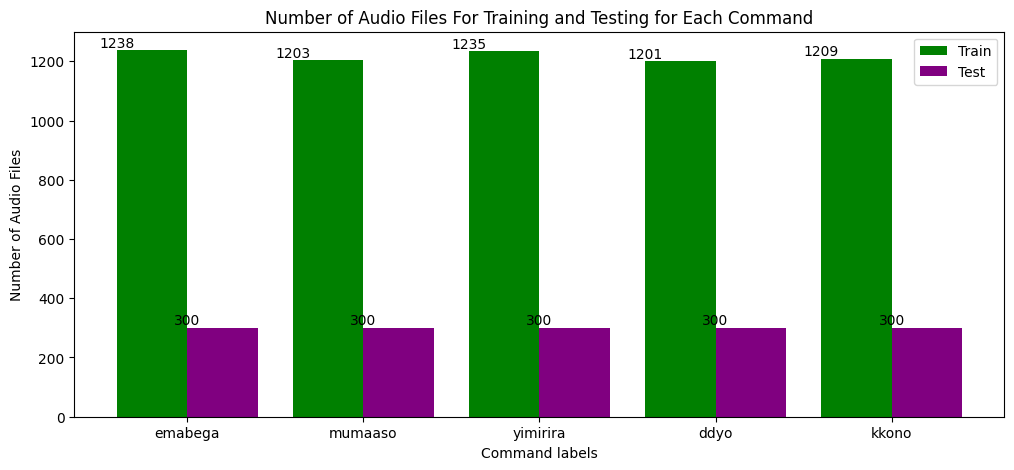

In [26]:
plot_audio_files_comparison(counts_train, counts_test)

### Augmentated Train and Test counts


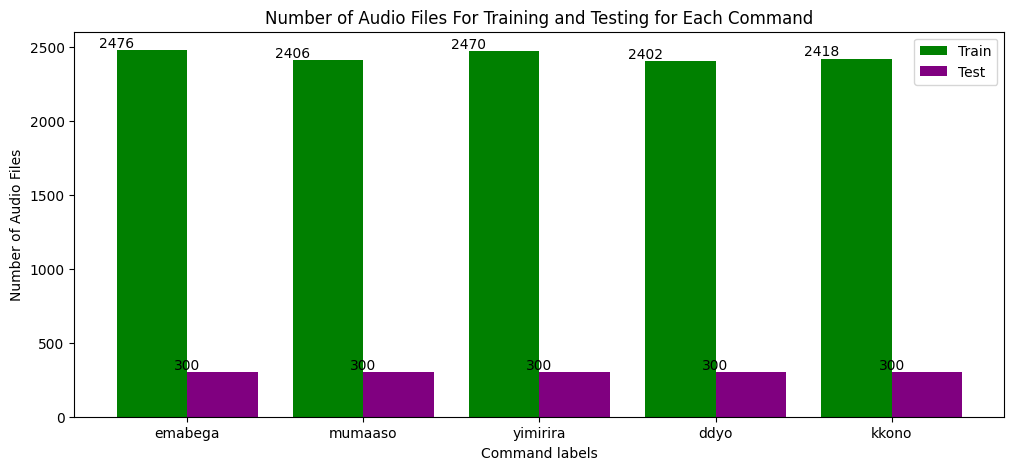

In [27]:
plot_audio_files_comparison(counts_aug_train, counts_test)

## Print the shortest and longeset audio files

In [28]:
# Function to print the shortest and longest audio files in each subfolder of a directory
def print_shortest_and_longest_audio_files(data_dir):
    try:
        for subfolder in os.listdir(data_dir):
            subfolder_path = os.path.join(data_dir, subfolder)
            if os.path.isdir(subfolder_path):
                shortest_audio = None
                longest_audio = None
                shortest_duration = float('inf')
                longest_duration = 0.0
                for audio_file in os.listdir(subfolder_path):
                    audio_path = os.path.join(subfolder_path, audio_file)
                    try:
                        with wave.open(audio_path, 'r') as wav_file:
                            audio_length = wav_file.getnframes() / wav_file.getframerate()
                        if audio_length < shortest_duration:
                            shortest_duration = audio_length
                            shortest_audio = audio_path
                        if audio_length > longest_duration:
                            longest_duration = audio_length
                            longest_audio = audio_path
                    except Exception as e:
                        print(f"Error processing {audio_path}: {e}")
                        continue
                print(f"In {subfolder}:")
                print(f"Shortest audio file: {shortest_audio} with duration: {shortest_duration} seconds")
                print(f"Longest audio file:  {longest_audio}  with duration: {longest_duration} seconds")
                print()
    except Exception as e:
        print(f"An error occurred while processing the directory: {e}")

### Train Dataset

In [29]:
print_shortest_and_longest_audio_files(train_data_dir)

In emabega:
Shortest audio file: Dataset/Train/emabega/emabega_536.wav with duration: 0.6385625 seconds
Longest audio file:  Dataset/Train/emabega/emabega_917.wav  with duration: 2.0 seconds

In mumaaso:
Shortest audio file: Dataset/Train/mumaaso/mumaaso_290.wav with duration: 0.53375 seconds
Longest audio file:  Dataset/Train/mumaaso/mumaaso_598.wav  with duration: 2.0 seconds

In yimirira:
Shortest audio file: Dataset/Train/yimirira/yimirira_1062.wav with duration: 0.0115625 seconds
Longest audio file:  Dataset/Train/yimirira/yimirira_689.wav  with duration: 2.0 seconds

In ddyo:
Shortest audio file: Dataset/Train/ddyo/ddyo_547.wav with duration: 0.3249375 seconds
Longest audio file:  Dataset/Train/ddyo/ddyo_503.wav  with duration: 1.998625 seconds

In gaali:
Shortest audio file: Dataset/Train/gaali/gaali_214.wav with duration: 0.011625 seconds
Longest audio file:  Dataset/Train/gaali/gaali_729.wav  with duration: 1.998625 seconds

In kkono:
Shortest audio file: Dataset/Train/kkono/k

### Test Dataset

In [30]:
print_shortest_and_longest_audio_files(test_data_dir)

In emabega:
Shortest audio file: Dataset/Test/emabega/emabega_294.wav with duration: 0.734375 seconds
Longest audio file:  Dataset/Test/emabega/emabega_297.wav  with duration: 2.0 seconds

In mumaaso:
Shortest audio file: Dataset/Test/mumaaso/mumaaso_039.wav with duration: 0.6153125 seconds
Longest audio file:  Dataset/Test/mumaaso/mumaaso_216.wav  with duration: 1.9969375 seconds

In yimirira:
Shortest audio file: Dataset/Test/yimirira/yimirira_059.wav with duration: 0.7198125 seconds
Longest audio file:  Dataset/Test/yimirira/yimirira_108.wav  with duration: 1.9978125 seconds

In ddyo:
Shortest audio file: Dataset/Test/ddyo/ddyo_237.wav with duration: 0.55725 seconds
Longest audio file:  Dataset/Test/ddyo/ddyo_066.wav  with duration: 2.0 seconds

In gaali:
Shortest audio file: Dataset/Test/gaali/gaali_248.wav with duration: 0.307625 seconds
Longest audio file:  Dataset/Test/gaali/gaali_004.wav  with duration: 2.0 seconds

In kkono:
Shortest audio file: Dataset/Test/kkono/kkono_050.wa

### Augmentated Train Dataset

In [31]:
print_shortest_and_longest_audio_files(aug_train_data_dir)

In emabega:
Shortest audio file: Dataset/New_Train/emabega/emabega_639.wav with duration: 2.0 seconds
Longest audio file:  Dataset/New_Train/emabega/emabega_639.wav  with duration: 2.0 seconds

In mumaaso:
Shortest audio file: Dataset/New_Train/mumaaso/mumaaso_339np.wav with duration: 2.0 seconds
Longest audio file:  Dataset/New_Train/mumaaso/mumaaso_339np.wav  with duration: 2.0 seconds

In yimirira:
Shortest audio file: Dataset/New_Train/yimirira/yimirira_145np.wav with duration: 2.0 seconds
Longest audio file:  Dataset/New_Train/yimirira/yimirira_145np.wav  with duration: 2.0 seconds

In ddyo:
Shortest audio file: Dataset/New_Train/ddyo/ddyo_132np.wav with duration: 2.0 seconds
Longest audio file:  Dataset/New_Train/ddyo/ddyo_132np.wav  with duration: 2.0 seconds

In gaali:
Shortest audio file: Dataset/New_Train/gaali/gaali_490.wav with duration: 2.0 seconds
Longest audio file:  Dataset/New_Train/gaali/gaali_490.wav  with duration: 2.0 seconds

In kkono:
Shortest audio file: Dataset

## Duration distribution

In [32]:
# Function to plot the distribution of audio lengths
def analyze_audio_duration(data_dir):
    durations = []
    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)
        if os.path.isdir(subfolder_path):
            for audio_file in os.listdir(subfolder_path):
                audio_path = os.path.join(subfolder_path, audio_file)
                try:
                    y, sr = librosa.load(audio_path)
                    duration = librosa.get_duration(y=y, sr=sr)
                    durations.append(duration)
                except Exception as e:
                    print(f"Error processing {audio_path}: {e}")
                    continue

    plt.hist(durations, bins=50)
    plt.xlabel('Duration (s)')
    plt.ylabel('Count')
    plt.title('Distribution of Audio Lengths')
    plt.show()

### Train Dataset

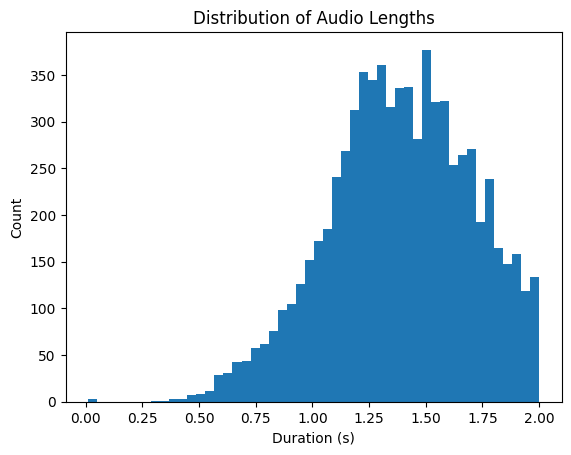

In [33]:
analyze_audio_duration(train_data_dir)

### Test Dataset

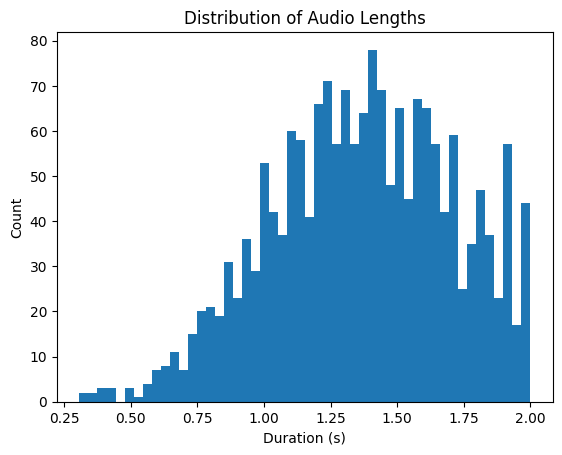

In [34]:
analyze_audio_duration(test_data_dir)

### Augmentated Train Dataset

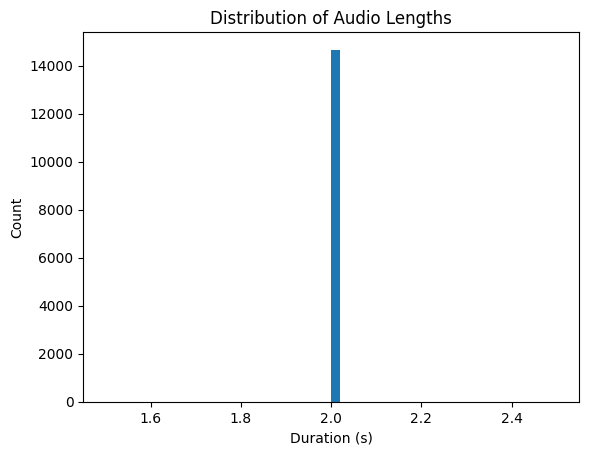

In [35]:
analyze_audio_duration(aug_train_data_dir)

## Audio File Properties and Visualization
- `Number of channels`
- `Sample rate`
- `Duration`
- `Number of frames`

Play the Audio  file

In [28]:
# Function to print audio properties
def print_audio_properties(file_path):
    if not os.path.isfile(file_path):
        print(f"File {file_path} does not exist.")
        return

    try:
        audio_signal, sample_rate = librosa.load(file_path, sr=None)
        with wave.open(file_path, 'rb') as audio:
            num_channels = audio.getnchannels()
            frame_rate = audio.getframerate()
            num_frames = audio.getnframes()
            duration = num_frames / float(frame_rate)

            print(f"\nAudio Properties for {os.path.basename(file_path)}")
            print(f"Number of channels:  {num_channels}")
            print(f"Sample rate (Hz):    {sample_rate}")
            print(f"Number of frames:    {num_frames}")
            print(f"Duration (s):        {duration}")
            print()
        
        # Play the audio files
        audio = Audio(file_path)
        display(audio)
    except Exception as e:
        print(f"An error occurred while processing the file: {e}")
    return

In [29]:
# Function to display the waveform, mel spectrogram and MFCC of an audio file
def display_waveform_mel_spectrogram_mfcc(file_path):
    try:
        audio_signal, sample_rate = librosa.load(file_path, sr=None)
        time = np.arange(0, len(audio_signal)) / sample_rate
        file_name = os.path.basename(file_path)
        fig, axs = plt.subplots(3, 1, figsize=(18, 15))

        # Plot waveform
        axs[0].plot(time, audio_signal)
        axs[0].set(xlabel='Time (s)', ylabel='Amplitude', title=f'Audio Signal Waveform - {file_name}')

        # Plot mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=sample_rate)
        img1 = librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), sr=sample_rate, x_axis='time', y_axis='mel', ax=axs[1])
        fig.colorbar(img1, ax=axs[1], format="%+2.f dB")
        axs[1].set(title=f'Mel Spectrogram - {file_name}', xlabel='Time (s)', ylabel='Mel Frequency')

        # Plot MFCC
        mfcc = librosa.feature.mfcc(y=audio_signal, sr=sample_rate)
        img2 = librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time', ax=axs[2])
        fig.colorbar(img2, ax=axs[2])
        axs[2].set(title=f'MFCC - {file_name}', xlabel='Time (s)', ylabel='MFCC')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error: {str(e)}")


### Emabega

In [30]:
print_audio_properties(emabega_file_path)


Audio Properties for emabega_001.wav
Number of channels:  1
Sample rate (Hz):    16000
Number of frames:    26563
Duration (s):        1.6601875



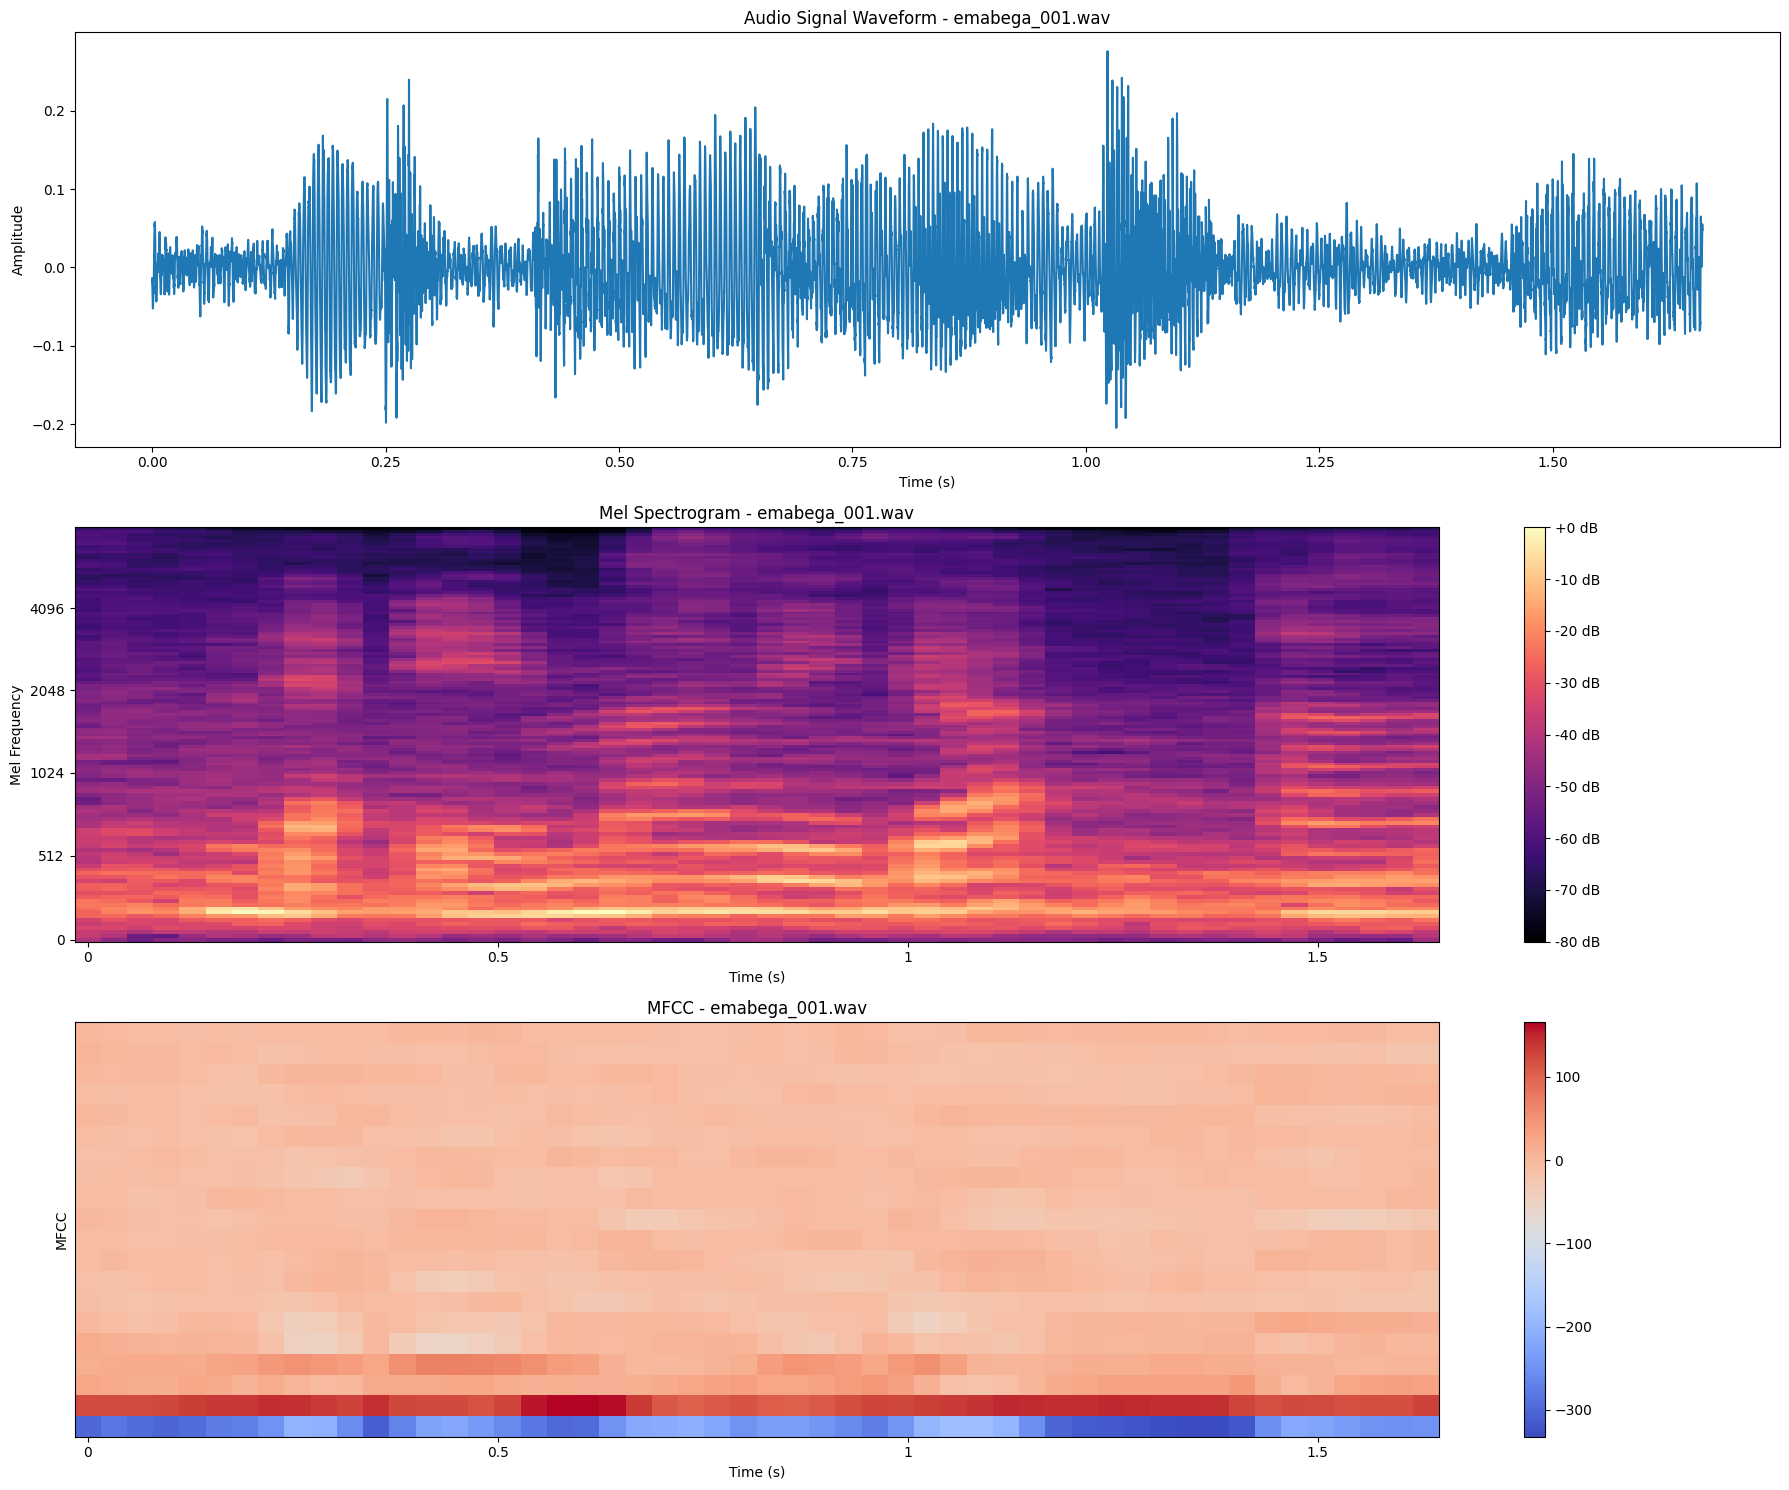

In [31]:
display_waveform_mel_spectrogram_mfcc(emabega_file_path)

### Ddyo

In [32]:
print_audio_properties(ddyo_file_path)


Audio Properties for ddyo_001.wav
Number of channels:  1
Sample rate (Hz):    16000
Number of frames:    12943
Duration (s):        0.8089375



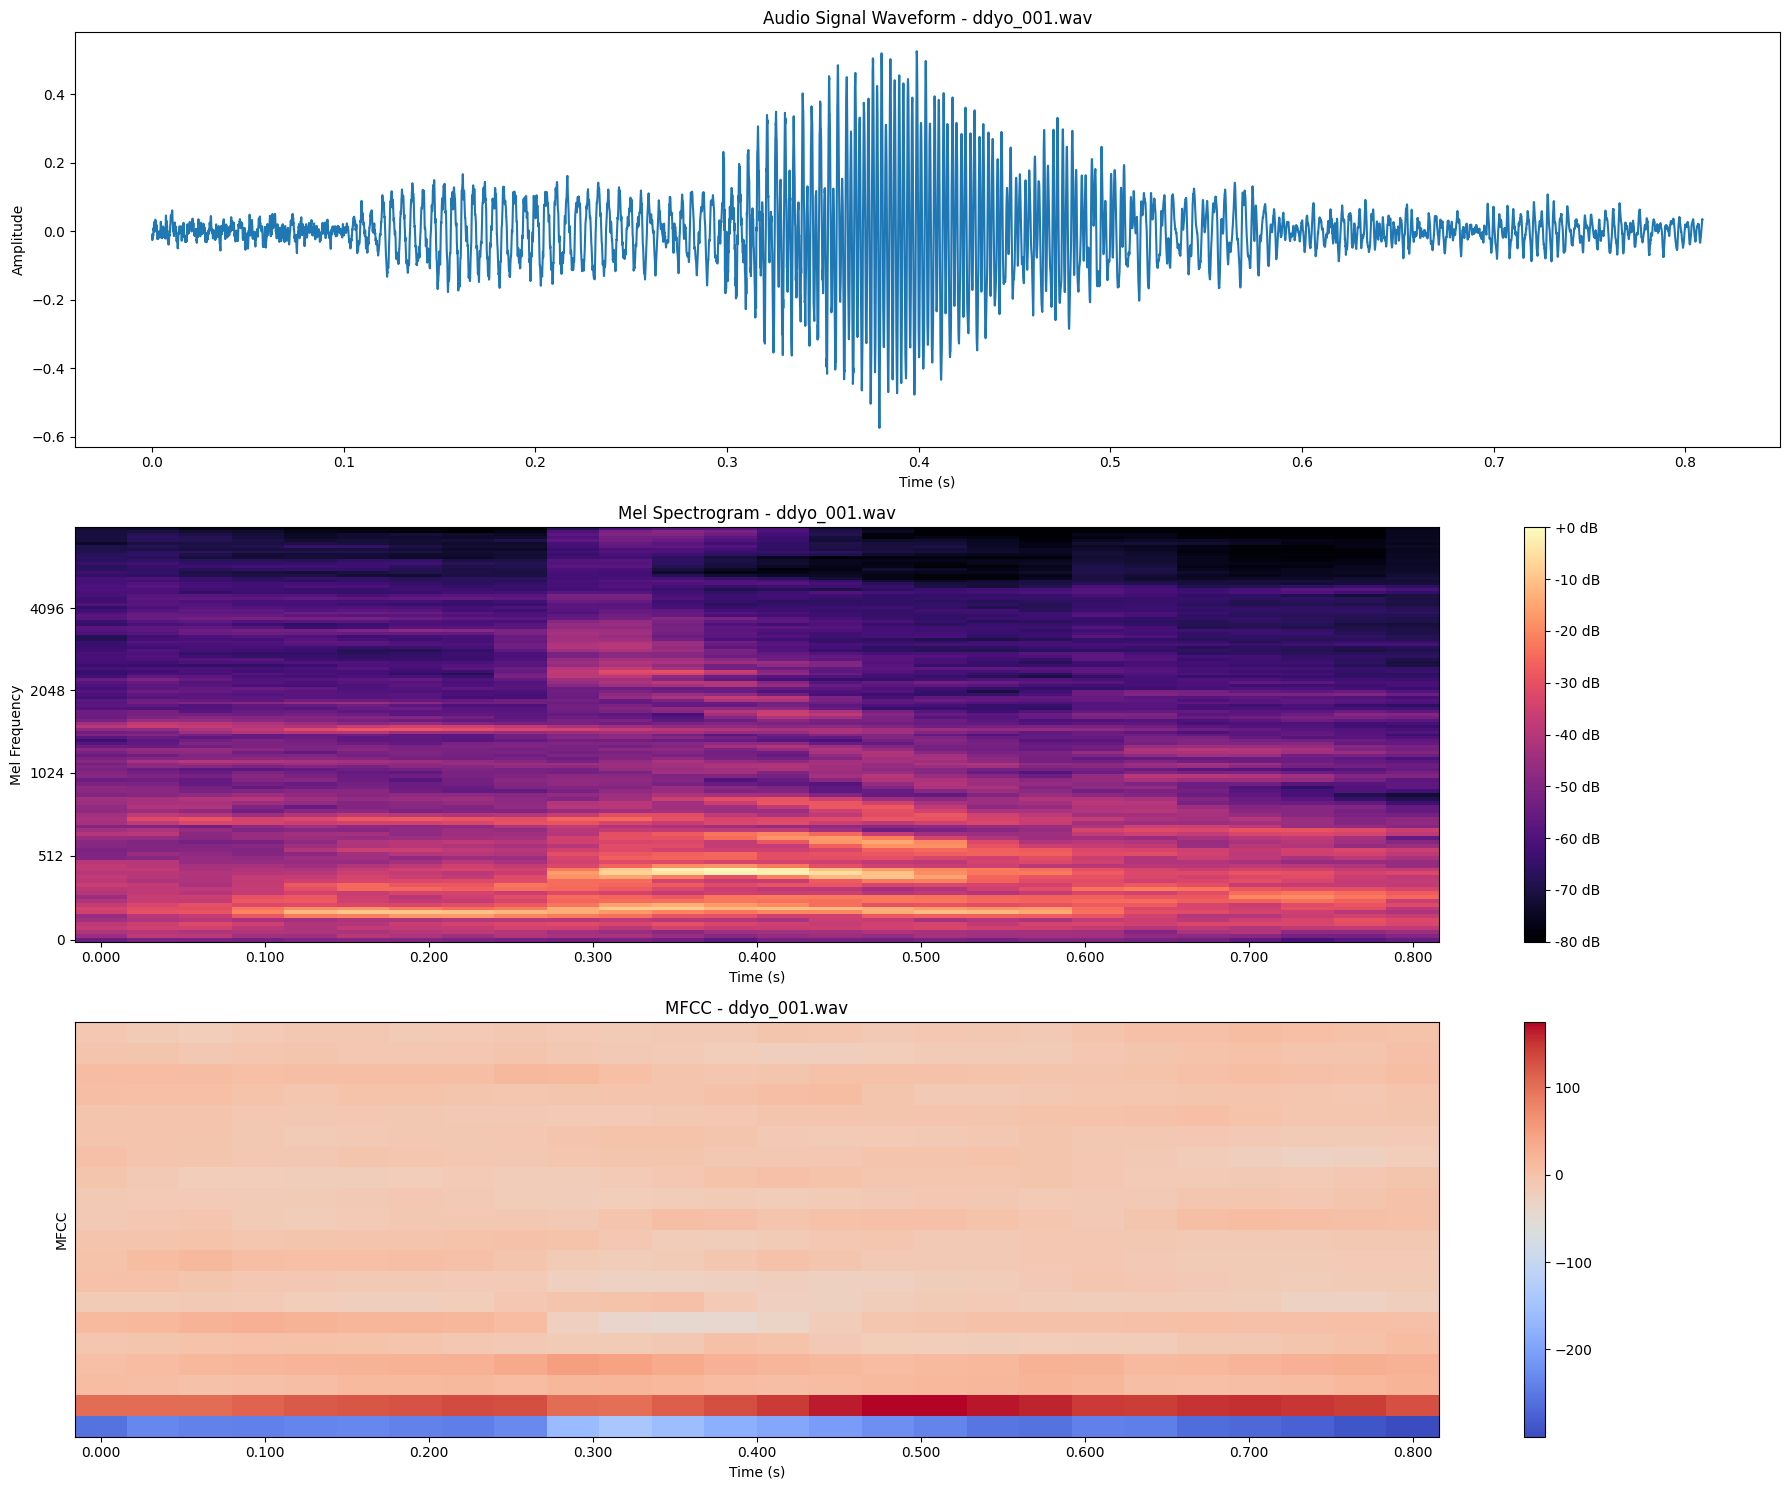

In [33]:
display_waveform_mel_spectrogram_mfcc(ddyo_file_path)

### Yimirira

In [34]:
print_audio_properties(yimirira_file_path)


Audio Properties for yimirira_015.wav
Number of channels:  1
Sample rate (Hz):    16000
Number of frames:    23909
Duration (s):        1.4943125



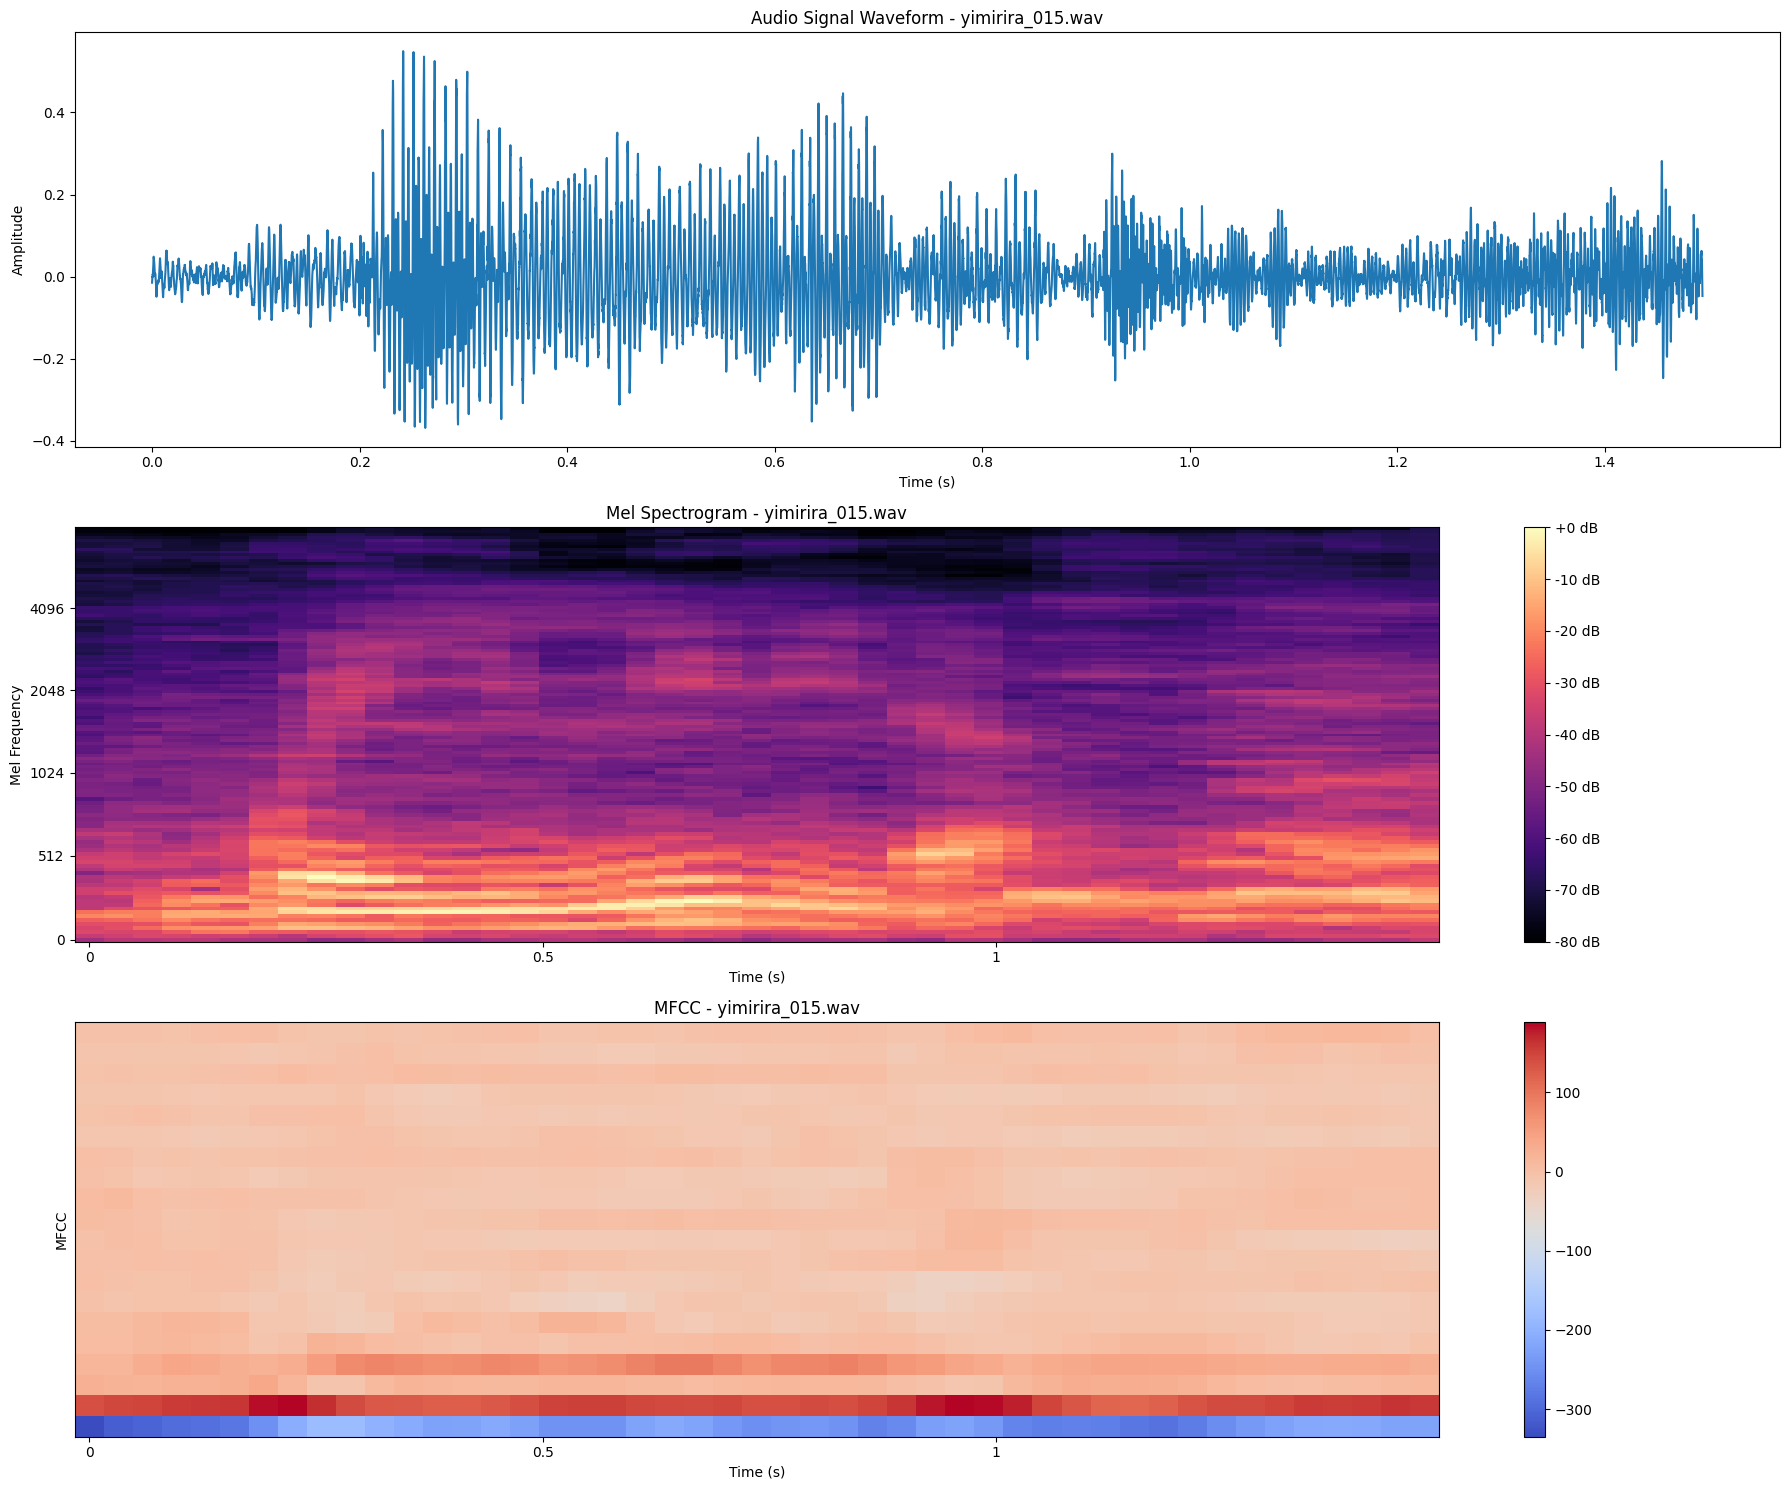

In [35]:
display_waveform_mel_spectrogram_mfcc(yimirira_file_path)

### Kkono

In [36]:
print_audio_properties(kkono_file_path)


Audio Properties for kkono_001.wav
Number of channels:  1
Sample rate (Hz):    16000
Number of frames:    26935
Duration (s):        1.6834375



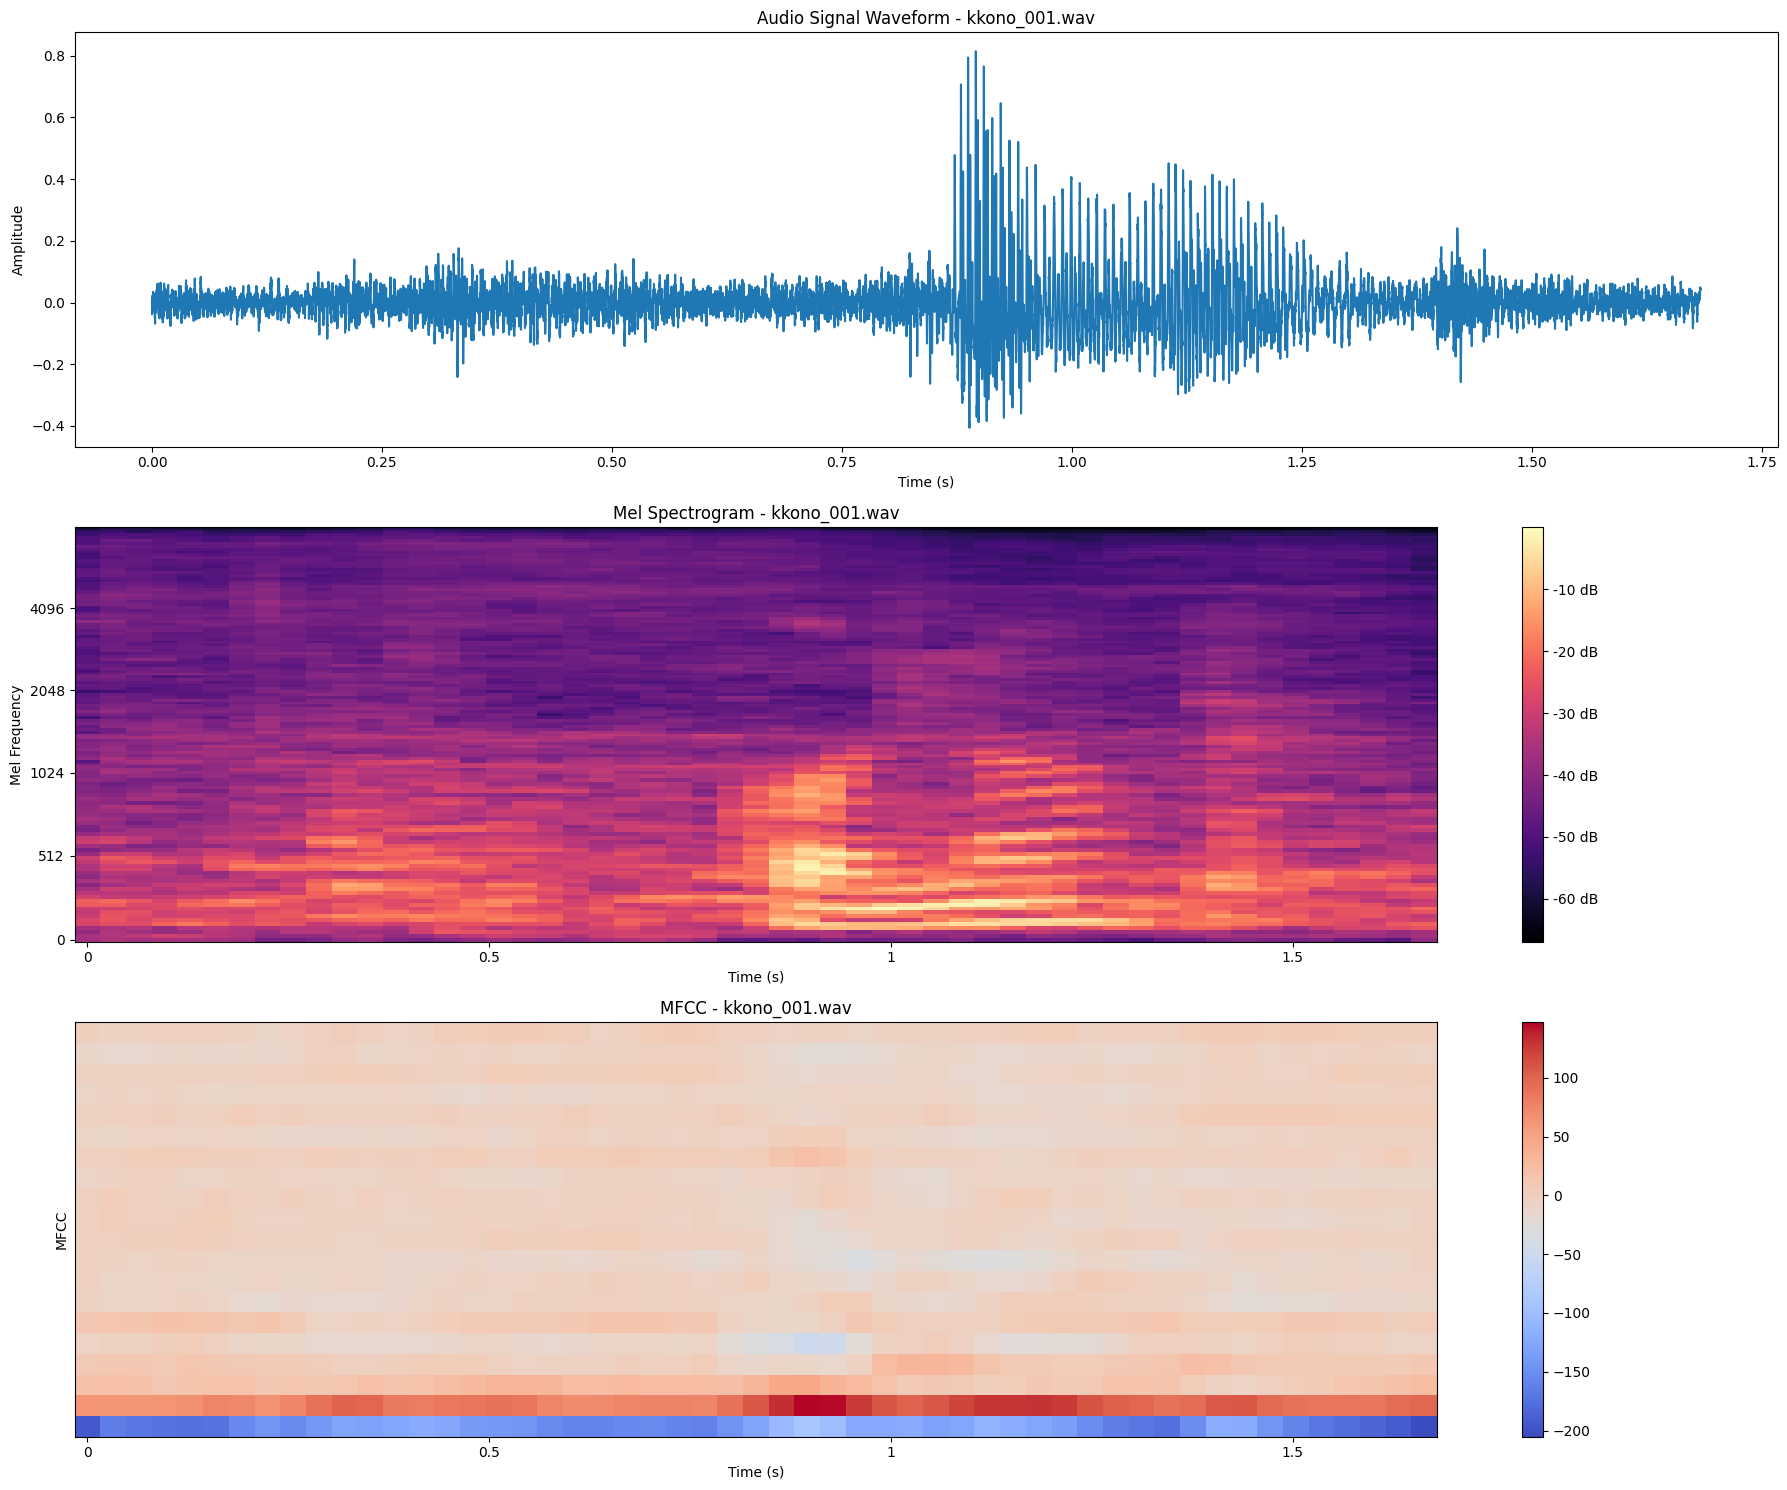

In [37]:
display_waveform_mel_spectrogram_mfcc(kkono_file_path)

### Mu maaso

In [38]:
print_audio_properties(mumasso_file_path)


Audio Properties for mumaaso_014.wav
Number of channels:  1
Sample rate (Hz):    16000
Number of frames:    20062
Duration (s):        1.253875



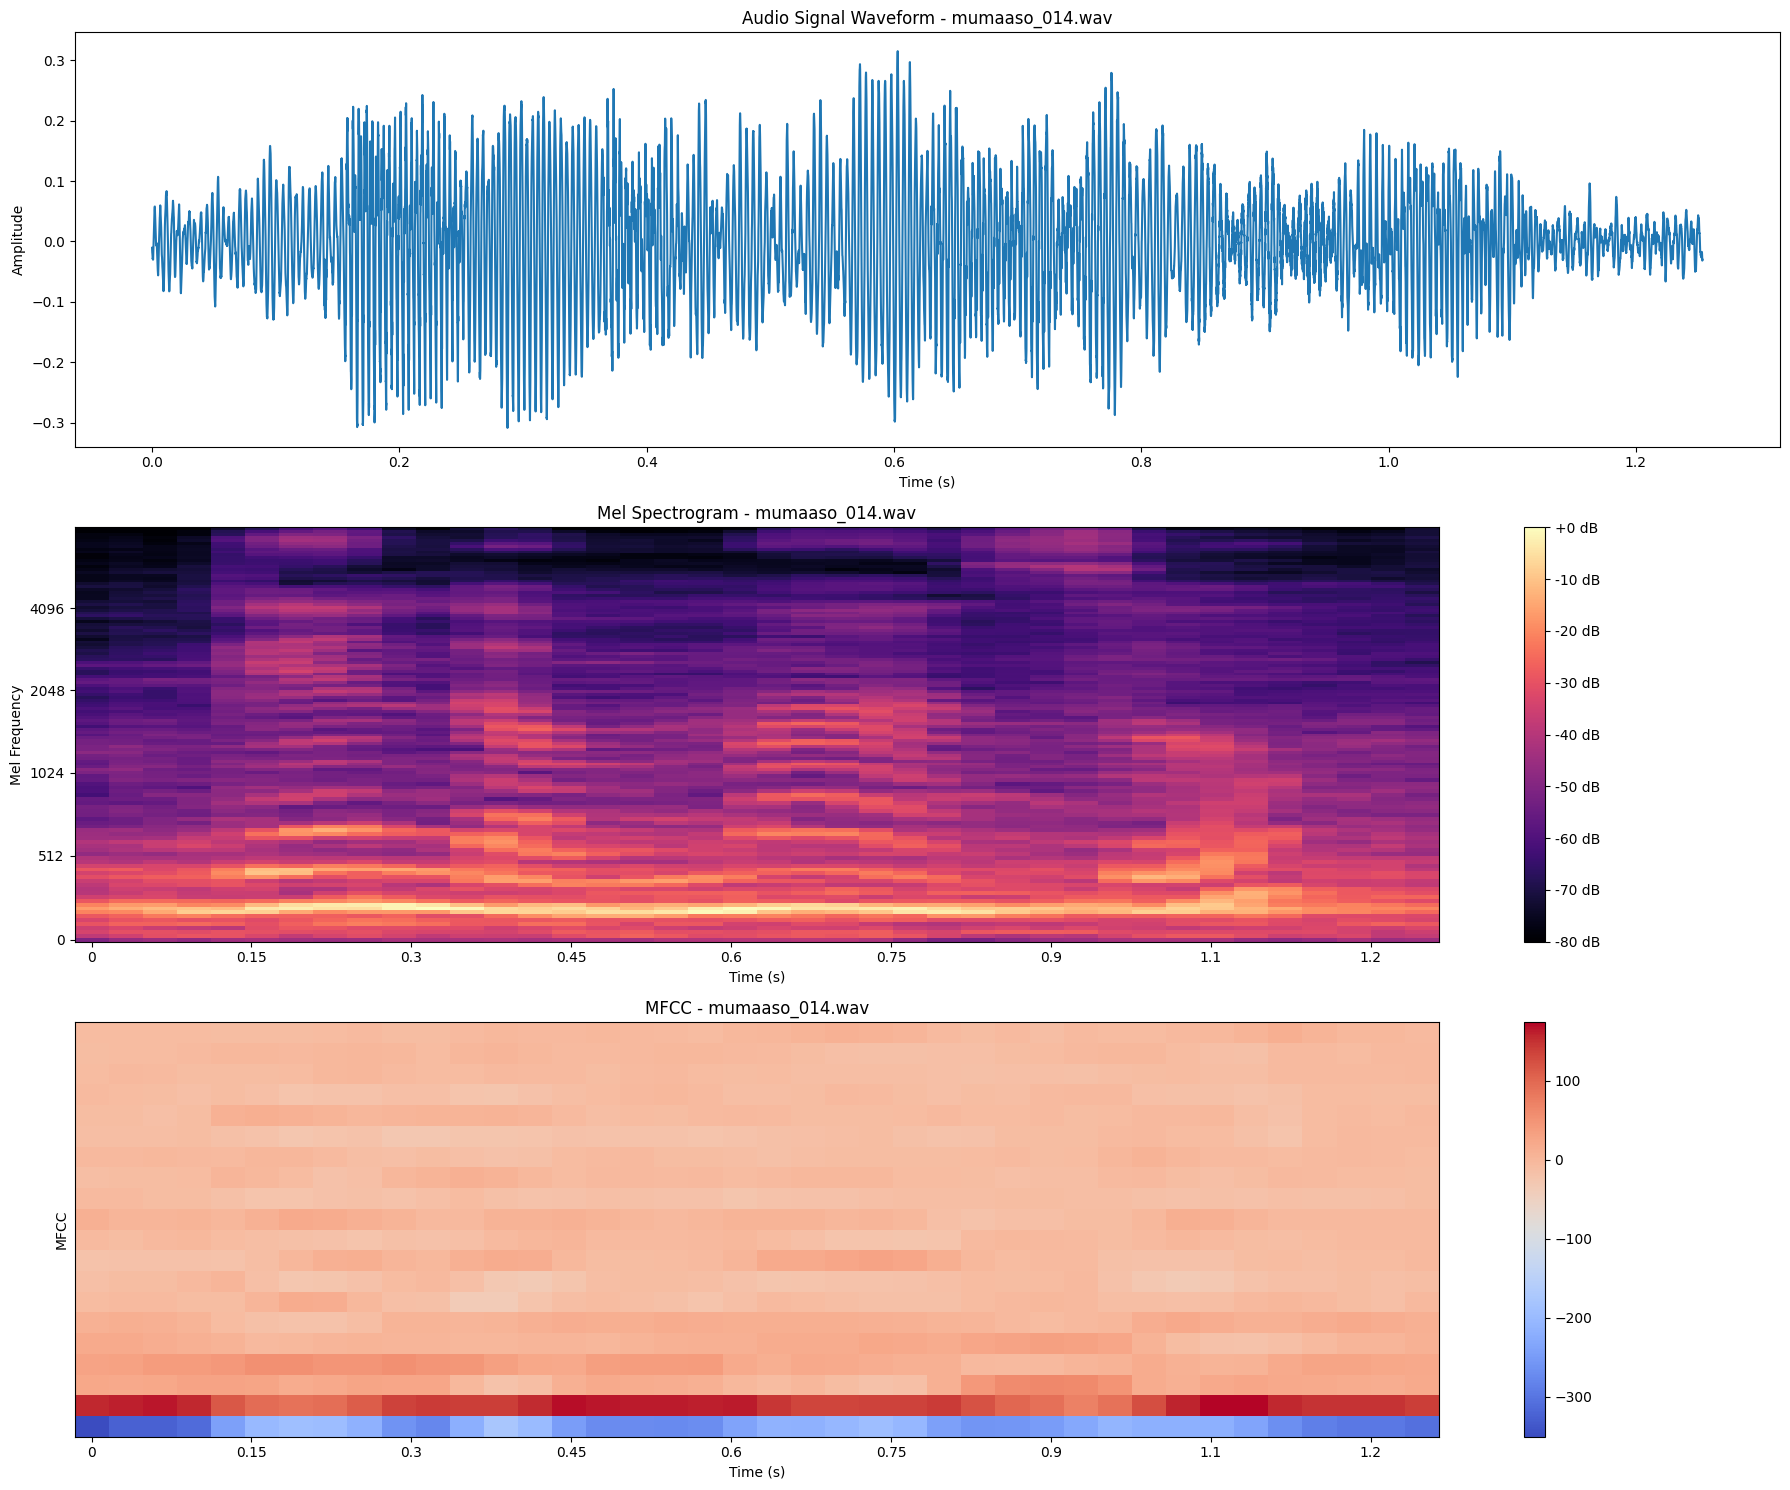

In [39]:
display_waveform_mel_spectrogram_mfcc(mumasso_file_path)

### Gaali

In [40]:
print_audio_properties(gaali_file_path)

File Dataset/Train/gaali/gaali_002.wav does not exist.


In [41]:
display_waveform_mel_spectrogram_mfcc(gaali_file_path)

Error: [Errno 2] No such file or directory: 'Dataset/Train/gaali/gaali_002.wav'


/tmp/ipykernel_42640/283042548.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_signal, sample_rate = librosa.load(file_path, sr=None)
/home/vx/Desktop/allenv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


### Ddyo

## Audio feature plots

### Waveforms

In [42]:
# Function to plot the audio signals of the first 6 audio files
def plot_audio_signals(file_paths, label_names_slice, sample_rate):
    rows, cols = 2, 3
    plt.figure(figsize=(18, 10))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        audio_signal, _ = librosa.load(file_paths[i], sr=sample_rate)
        time = np.arange(0, len(audio_signal)) / sample_rate
        plt.plot(time, audio_signal)
        plt.title(label_names_slice[i])
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.ylim([-1.1, 1.1])
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_42640/4120664144.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_signal, _ = librosa.load(file_paths[i], sr=sample_rate)


FileNotFoundError: [Errno 2] No such file or directory: 'Dataset/Train/gaali/gaali_002.wav'

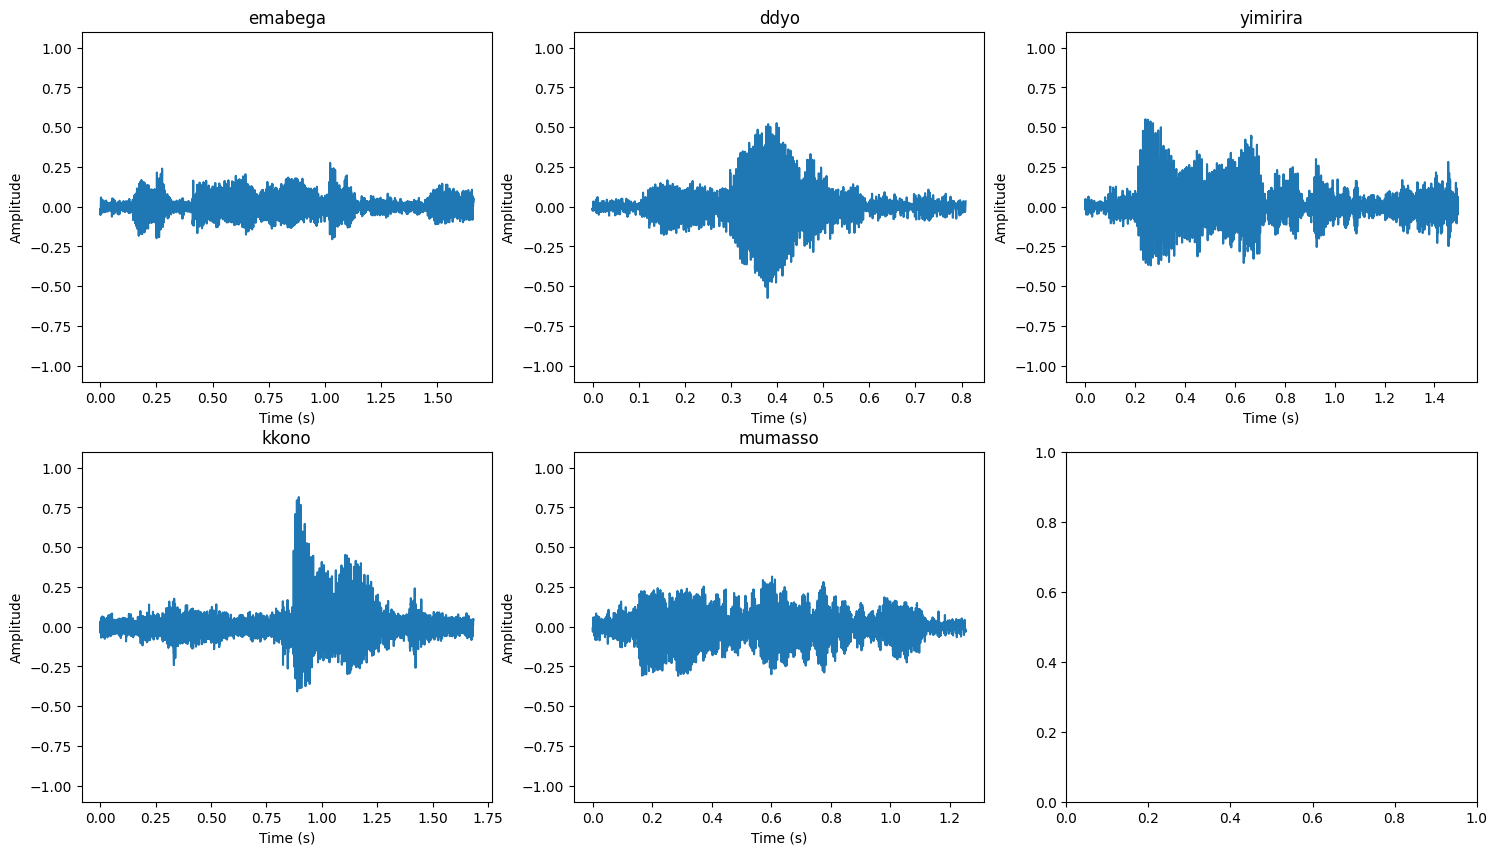

In [43]:
label_names_slice =  ['emabega', 'ddyo', 'yimirira', 'kkono', 'mumasso', 'gaali']
plot_audio_signals(file_paths, label_names_slice, SAMPLE_RATE)

### Mel_Spectrogram

In [44]:
# Function to plot the mel spectrograms of the first 6 audio files
def plot_spectrograms(file_paths, label_names_slice):
    rows, cols = 2, 3
    plt.figure(figsize=(18, 10))
    for i, audio_file in enumerate(file_paths):
        try:
            plt.subplot(rows, cols, i+1)
            audio_signal, sample_rate = librosa.load(audio_file, sr=None)
            spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=sample_rate)
            img = librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sample_rate, x_axis='time', y_axis='mel')
            plt.colorbar(img, format="%+2.f dB")
            plt.title(label_names_slice[i])
            plt.xlabel('Time (s)')
            plt.ylabel('Mel Frequency')
        except Exception as e:
            print(f"Error: {str(e)}")
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_42640/3157557116.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_signal, sample_rate = librosa.load(audio_file, sr=None)


Error: [Errno 2] No such file or directory: 'Dataset/Train/gaali/gaali_002.wav'


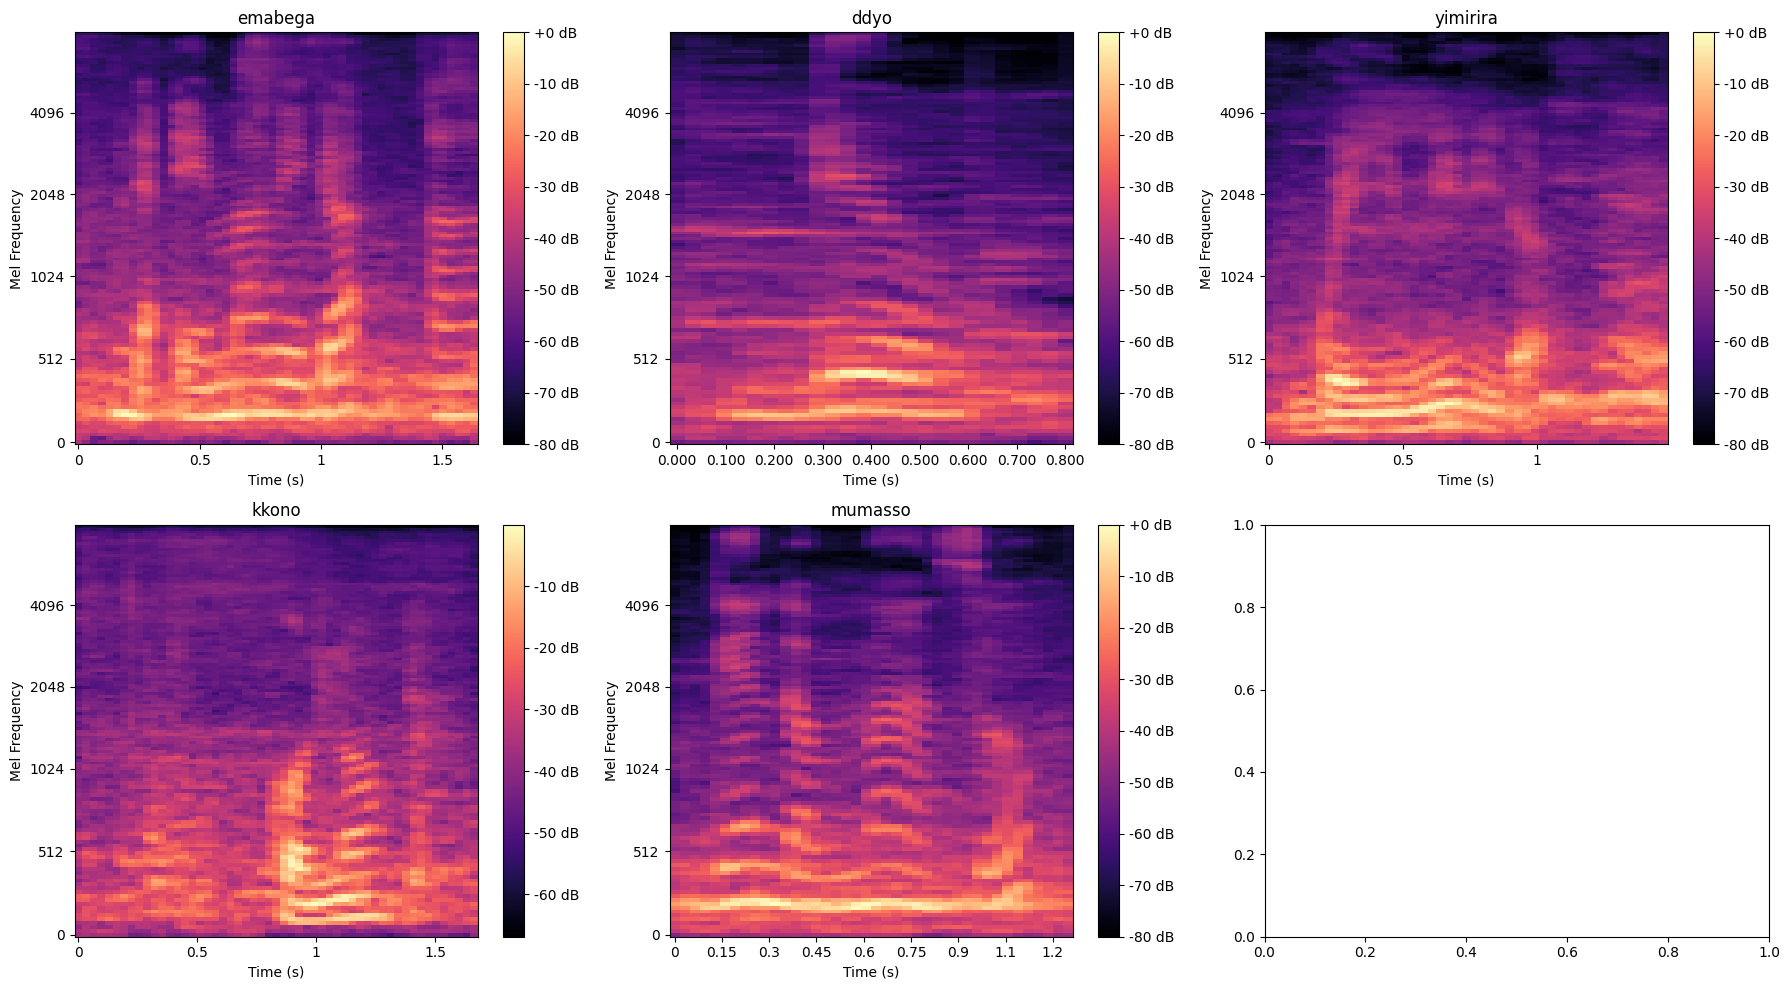

In [45]:
label_names_slice =  ['emabega', 'ddyo', 'yimirira', 'kkono', 'mumasso', 'gaali']
plot_spectrograms(file_paths, label_names_slice)

### MFCCs

In [46]:

# Function to plot the MFCC of the first 6 audio files
def plot_mfcc(file_paths, label_names_slice):
    rows, cols = 2, 3
    plt.figure(figsize=(18, 10))
    for i, audio_file in enumerate(file_paths):
        try:
            plt.subplot(rows, cols, i+1)
            audio_signal, sample_rate = librosa.load(audio_file, sr=None)
            mfcc = librosa.feature.mfcc(y=audio_signal, sr=sample_rate)
            img = librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
            plt.colorbar(img)
            plt.title(label_names_slice[i])
            plt.xlabel('Time (s)')
            plt.ylabel('MFCC')
        except Exception as e:
            print(f"Error: {str(e)}")
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_42640/4242233457.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_signal, sample_rate = librosa.load(audio_file, sr=None)


Error: [Errno 2] No such file or directory: 'Dataset/Train/gaali/gaali_002.wav'


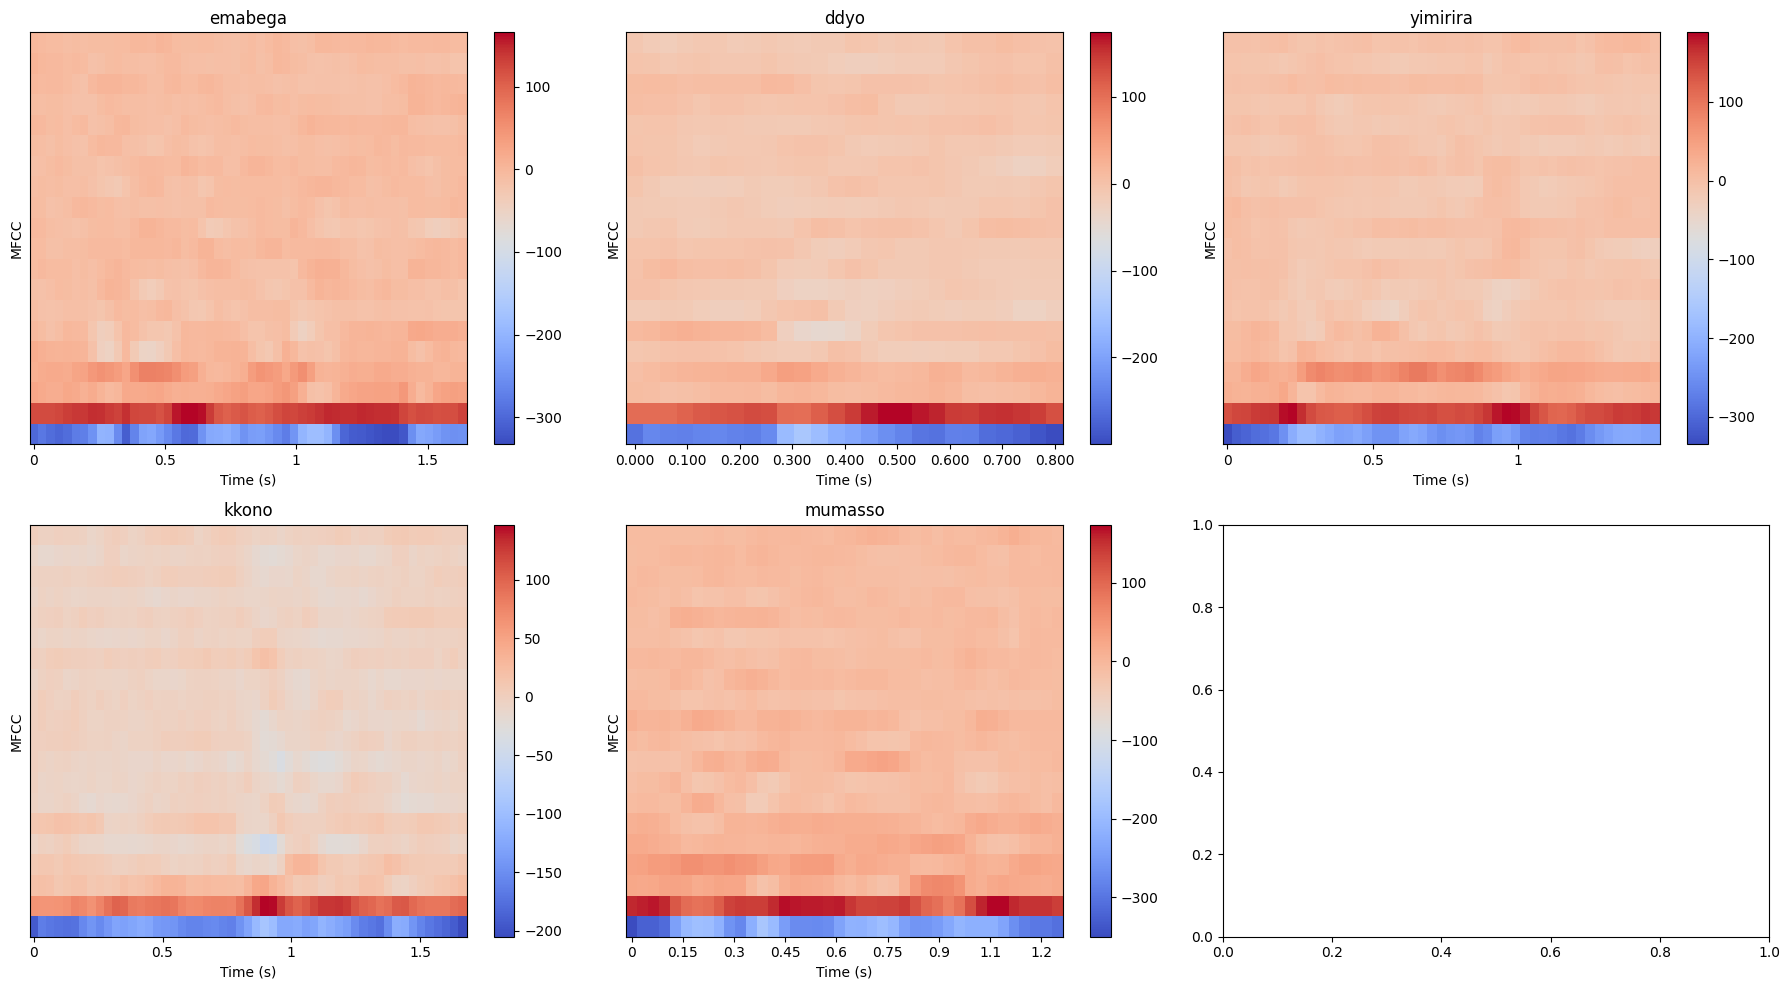

In [47]:
label_names_slice =  ['emabega', 'ddyo', 'yimirira', 'kkono', 'mumasso', 'gaali']
plot_mfcc(file_paths, label_names_slice)

# Wave comparison of original and augmentated audio files

In [48]:
def plot_waveforms_comparison(file1, file2):
    # Load audio files
    audio1, sr1 = librosa.load(file1, sr=None)
    audio2, sr2 = librosa.load(file2, sr=None)

    # Create time axis
    time1 = librosa.times_like(audio1, sr=sr1)
    time2 = librosa.times_like(audio2, sr=sr2)

    # Plot waveforms
    plt.figure(figsize=(12, 10))  # Change the figure size to make it vertical
    plt.subplot(2, 1, 1)  # Change the subplot configuration to be vertical
    plt.plot(time1, audio1)
    plt.title('Original audio waveplot')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)  # Change the subplot configuration to be vertical
    plt.plot(time2, audio2)
    plt.title('Augmentated audio waveplot')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

### Emabega

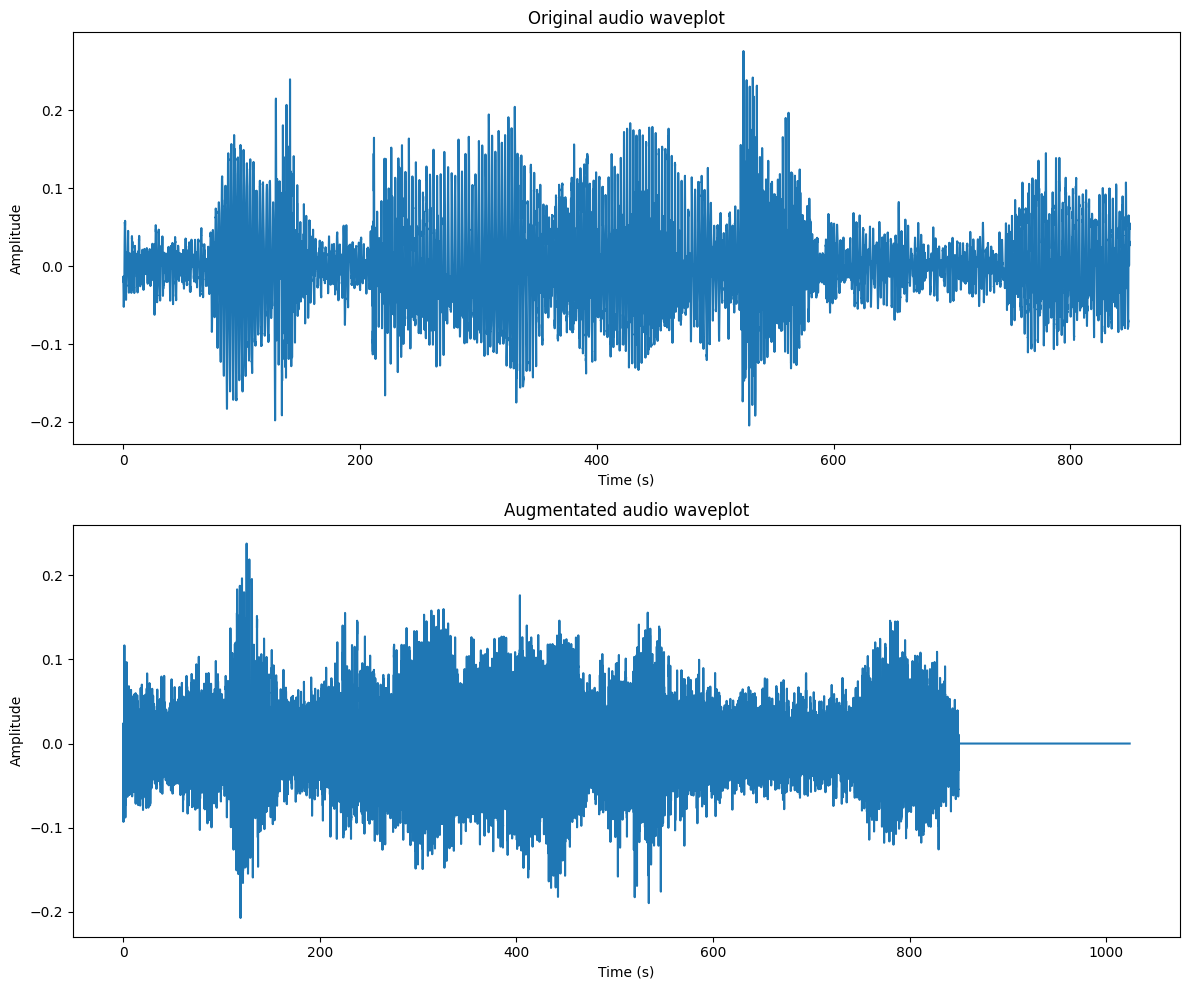

In [49]:
plot_waveforms_comparison(emabega_file_path, emabega_file_path_np)

### Ddyo

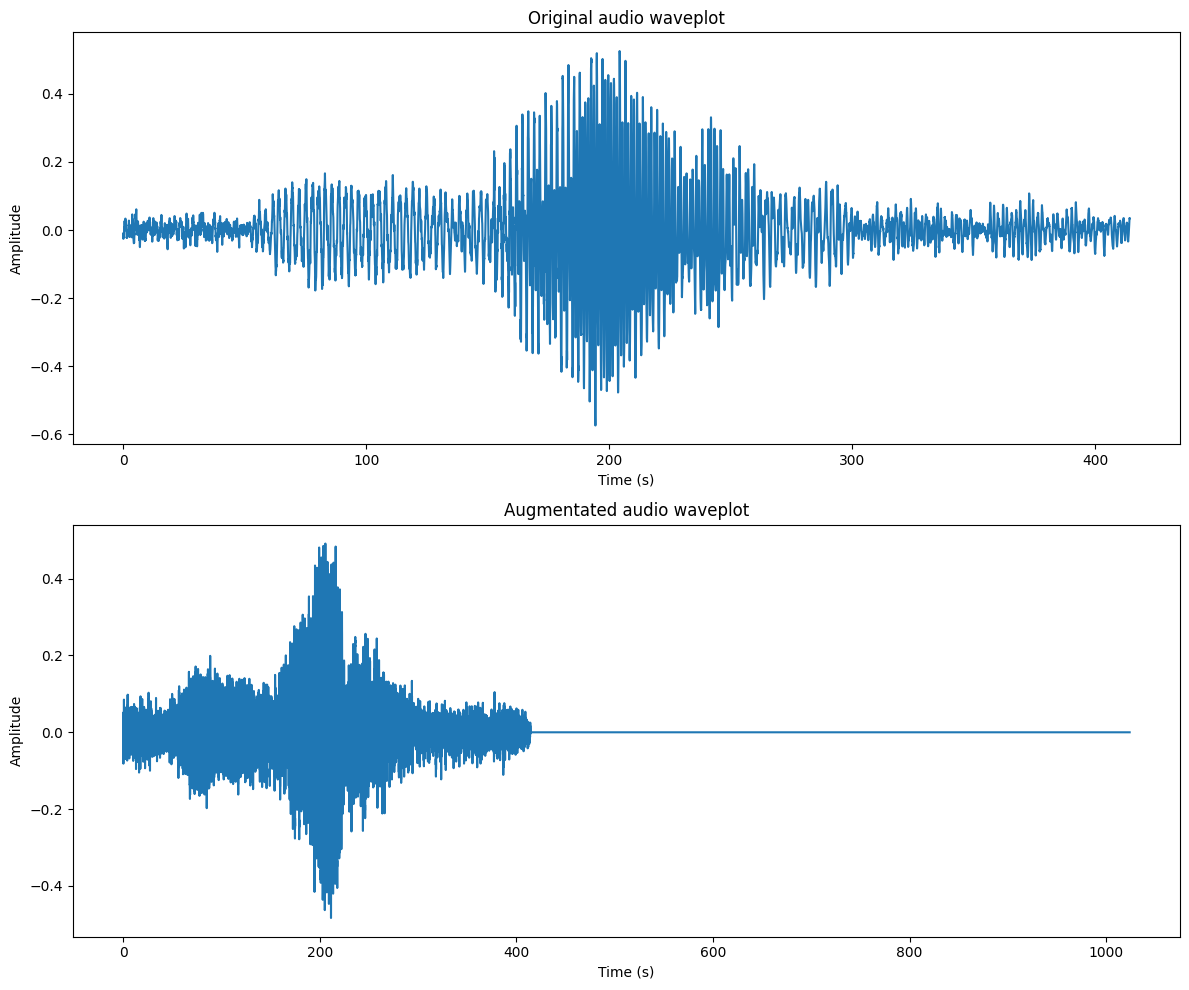

In [50]:
plot_waveforms_comparison(ddyo_file_path, ddyo_file_path_np)

### Yimirira

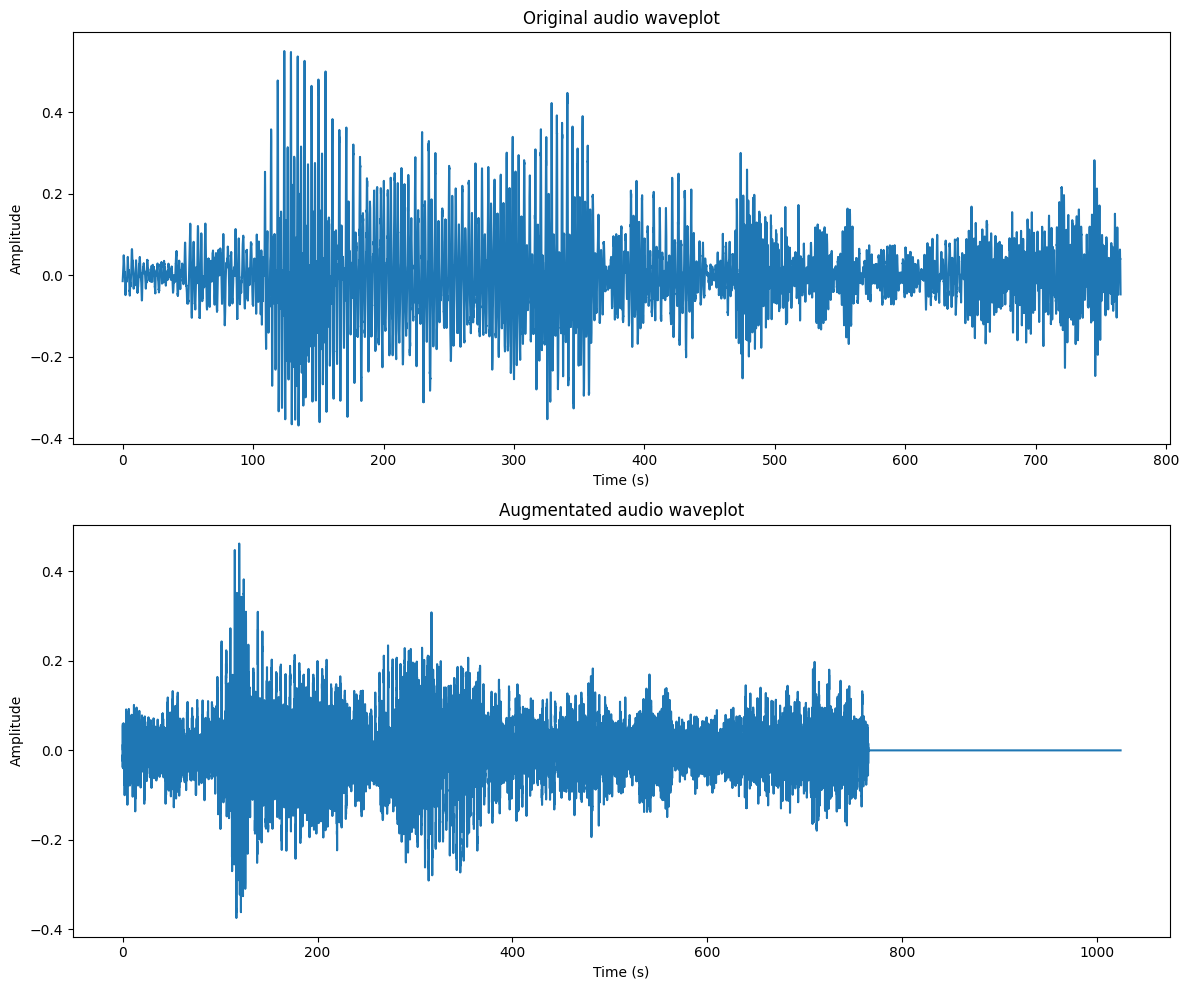

In [51]:
plot_waveforms_comparison(yimirira_file_path, yimirira_file_path_np)

### Kkono

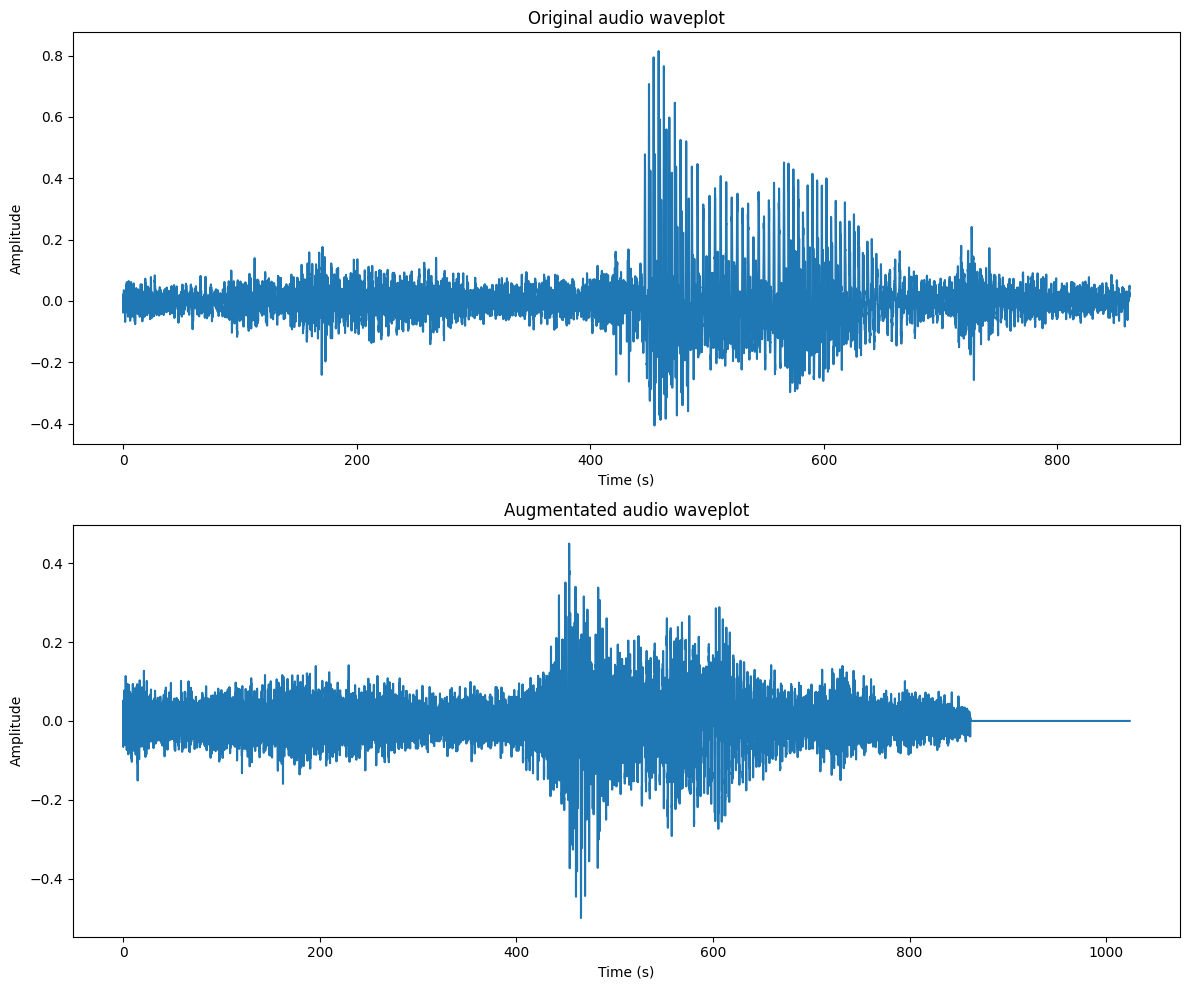

In [52]:
plot_waveforms_comparison(kkono_file_path, kkono_file_path_np)

### Mu maaso

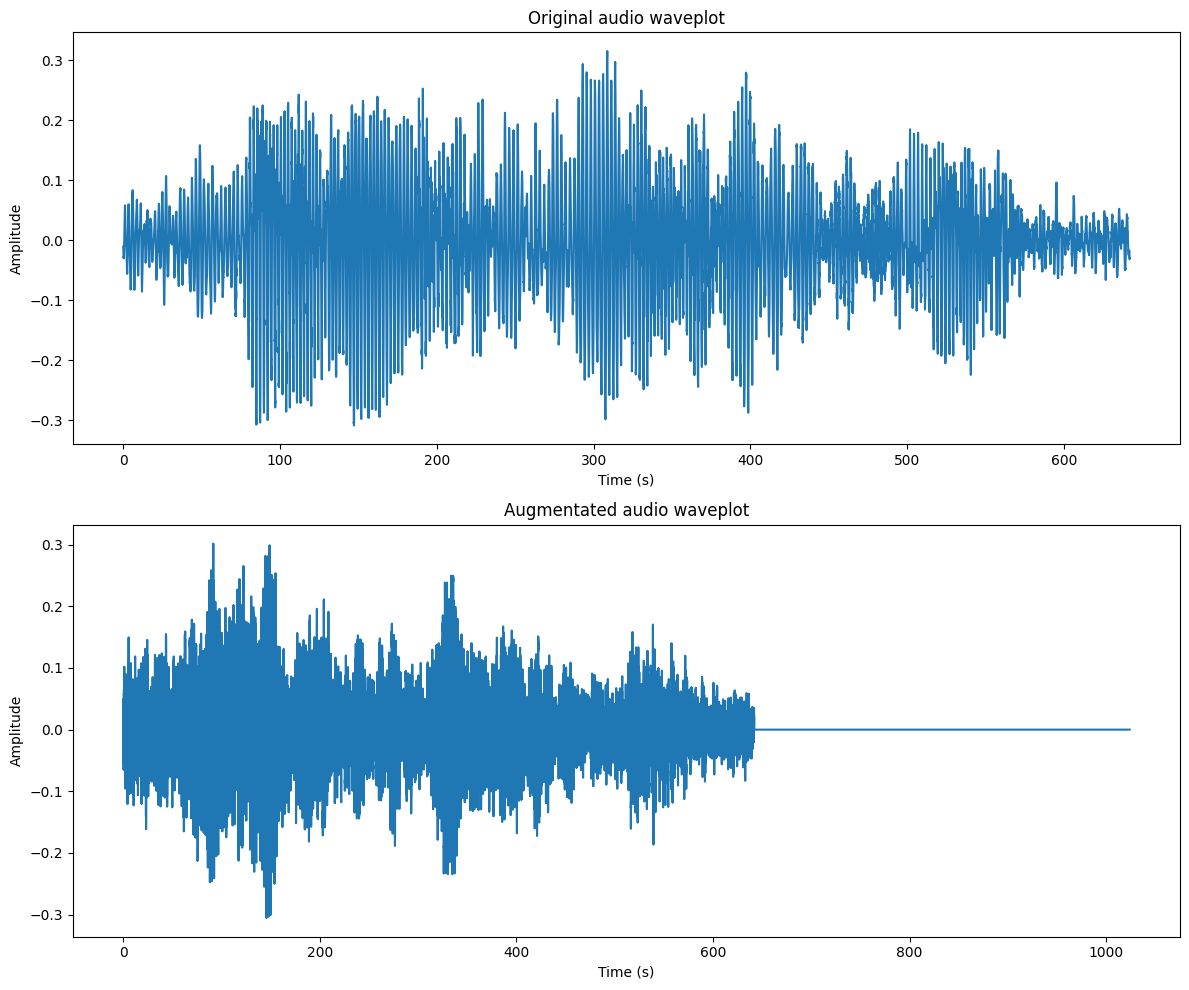

In [61]:
plot_waveforms_comparison(mumasso_file_path, mumasso_file_path_np)

### Gaali

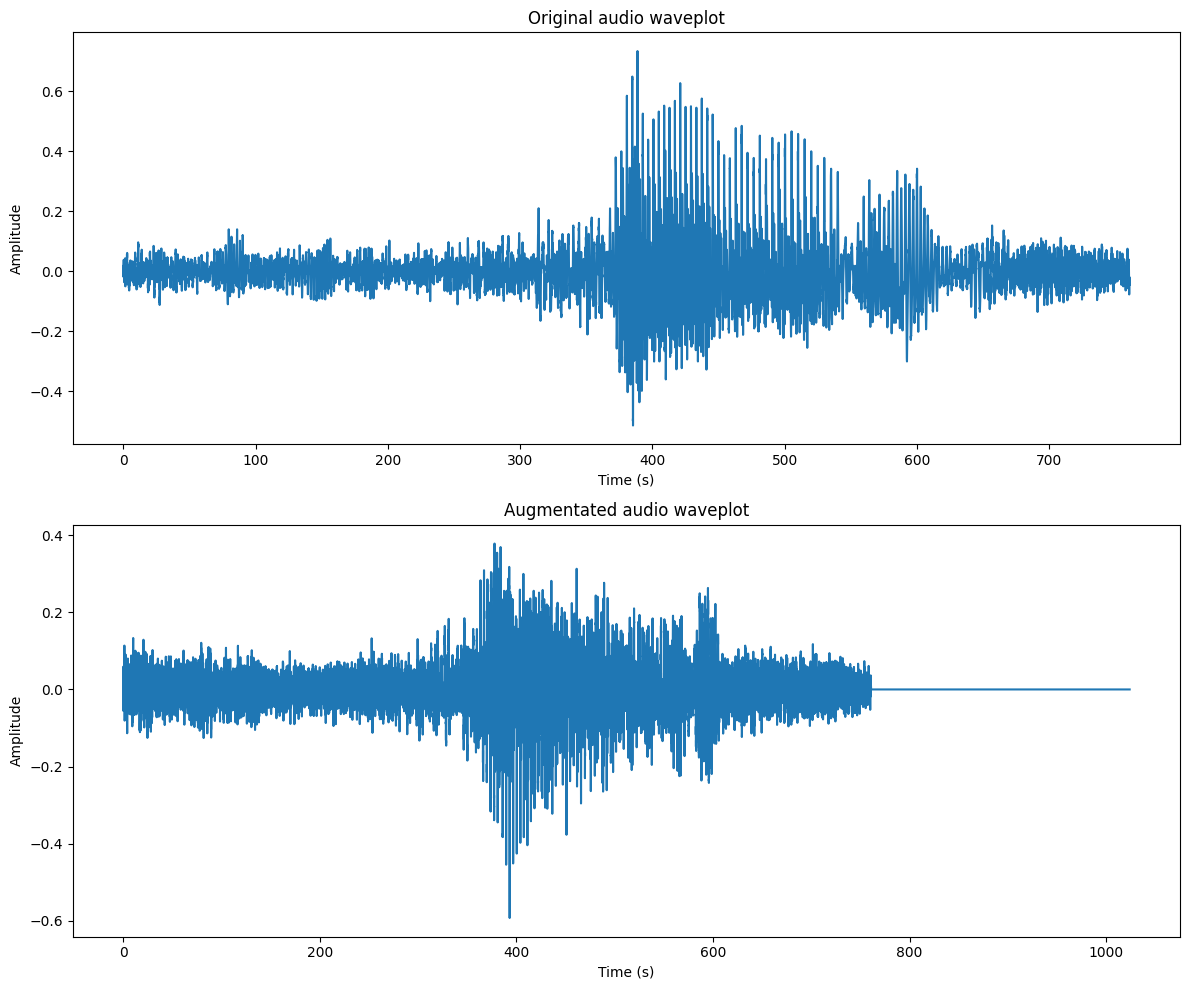

In [62]:
plot_waveforms_comparison(gaali_file_path, gaali_file_path_np)